## Kaggle - Predicting Bike Sharing Demand

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these Bike Sharing systems, people rent a bike from one location and return it to a different or same place on need basis. People can rent a bike through membership (mostly regular users) or on demand basis (mostly casual users). This process is controlled by a network of automated kiosk across the city.

In [Kaggle Bike Sharing Demand](https://www.kaggle.com/c/bike-sharing-demand), the participants were asked to forecast bike rental demand of Bike sharing program in Washington, D.C. based on historical usage patterns in relation with weather, time and other data.

I have compiled this notebook by collating theory and codes from other blogs as well along with my own implementations. Wherever I have copied the theory/codes verbatim I have highlighted the references with <sup>[1]</sup> to give the authors their due credit. Please refer to the reference section at the end of the notebook for the original blogs of the respective authors.

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import seaborn as sns
import matplotlib.pyplot as plt

D:\Work\Anaconda3\envs\tensorflow-gpu\lib\site-packages\IPython\html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 500)
pd.options.display.max_colwidth = 30

#sns.set_style("whitegrid")
#plt.style.use('bmh')
plt.style.use('seaborn-whitegrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### 1. Hypothesis Generation

Before exploring the data to understand the relationship between variables, it is recommended that we focus on hypothesis generation first. Now, this might sound counter-intuitive for solving a data science problem, but before exploring data, we should spend some time thinking about the business problem, gaining the domain knowledge and may be gaining first hand experience of the problem.

How does it help? This practice usually helps us form better features later on, which are not biased by the data available in the dataset. At this stage, we are expected to posses structured thinking i.e. a thinking process which takes into consideration all the possible aspects of a particular problem.

Here are some of the hypothesis which could influence the demand of bikes:

**Hourly trend:** There must be high demand during office timings. Early morning and late evening can have different trend (cyclist) and low demand during 10:00 pm to 4:00 am.

**Daily Trend:** Registered users demand more bike on weekdays as compared to weekend or holiday.

**Rain:** The demand of bikes will be lower on a rainy day as compared to a sunny day. Similarly, higher humidity will cause to lower the demand and vice versa.

**Temperature:** In India, temperature has negative correlation with bike demand. But, after looking at Washington's temperature graph, we presume it may have positive correlation.

**Pollution:** If the pollution level in a city starts soaring, people may start using Bike (it may be influenced by government / company policies or increased awareness).

**Time:** Total demand should have higher contribution of registered user as compared to casual because registered user base would increase over time.

**Traffic:** It can be positively correlated with Bike demand. Higher traffic may force people to use bike as compared to other road transport medium like car, taxi etc.

### 2. Understanding the Data Set

The dataset shows hourly rental data for two years (2011 and 2012). The training data set is for the first 19 days of each month. The test dataset is from 20th day to month's end. We are required to predict the total count of bikes rented during each hour covered by the test set.

In the training data set, they have separately given bike demand by registered, casual users and sum of both is given as count.

Training data set has 12 variables (see below) and Test has 9 (excluding registered, casual and count).

<p style="text-align: justify;"><strong>Independent Variables</strong></p>
<pre><strong>datetime:   </strong>date and hour in "mm/dd/yyyy hh:mm" format
<strong>season:</strong> &nbsp;   Four categories-&gt; 1 = spring, 2 = summer, 3 = fall, 4 = winter
<strong>holiday:</strong>    whether the day is a holiday or not (1/0)
<strong>workingday:</strong> whether the day is neither a weekend nor holiday (1/0)
<strong>weather:</strong>&nbsp;   Four Categories of weather
            1-&gt; Clear, Few clouds, Partly cloudy, Partly cloudy
            2-&gt; Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
            3-&gt; Light Snow and Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
            4-&gt; Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
<strong>temp:</strong>       hourly temperature in Celsius
<strong>atemp:</strong>      "feels like" temperature in Celsius
<strong>humidity:</strong>   relative humidity
<strong>windspeed:</strong>  wind speed
</pre>

<p><strong>Dependent Variables</strong></p>
<pre><strong>registered:</strong> number of registered user
<strong>casual:</strong>     number of non-registered user
<strong>count:</strong>      number of total rentals (registered + casual)
</pre> 

### 3. Importing Data Set and Basic Data Exploration

In [3]:
train_df = pd.read_csv('data/train.csv')
train_df['data_set'] = 'train'
train_df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count,data_set
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,train
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,train
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,train
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,train
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,train


In [4]:
test_df = pd.read_csv('data/test.csv')
test_df['data_set'] = 'test'
test_df.head(5)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,data_set
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027,test
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000,test
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000,test
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014,test
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014,test


#### 3.1. Combine both Train and Test Data set (to understand the distribution of independent variable together).

In [5]:
# combine train and test data into one df
test_df['registered'] = 0
test_df['casual'] = 0
test_df['count'] = 0

all_df = pd.concat([train_df, test_df])
all_df.head(5)

,atemp,casual,count,data_set,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday
0,14.395,3,16,train,2011-01-01 00:00:00,0,81,13,1,9.84,1,0.0,0
1,13.635,8,40,train,2011-01-01 01:00:00,0,80,32,1,9.02,1,0.0,0
2,13.635,5,32,train,2011-01-01 02:00:00,0,80,27,1,9.02,1,0.0,0
3,14.395,3,13,train,2011-01-01 03:00:00,0,75,10,1,9.84,1,0.0,0
4,14.395,0,1,train,2011-01-01 04:00:00,0,75,1,1,9.84,1,0.0,0


In [6]:
all_df.tail(5)

,atemp,casual,count,data_set,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday
6488,12.880,0,0,test,2012-12-31 19:00:00,0,60,0,1,10.66,2,11.0014,1
6489,12.880,0,0,test,2012-12-31 20:00:00,0,60,0,1,10.66,2,11.0014,1
6490,12.880,0,0,test,2012-12-31 21:00:00,0,60,0,1,10.66,1,11.0014,1
6491,13.635,0,0,test,2012-12-31 22:00:00,0,56,0,1,10.66,1,8.9981,1
6492,13.635,0,0,test,2012-12-31 23:00:00,0,65,0,1,10.66,1,8.9981,1


In [7]:
# lowercase column names
all_df.columns = map(str.lower, all_df.columns)
all_df.columns

Index(['atemp', 'casual', 'count', 'data_set', 'datetime', 'holiday',
       'humidity', 'registered', 'season', 'temp', 'weather', 'windspeed',
       'workingday'],
      dtype='object')

In [8]:
# parse datetime colum & add new time related columns
dt = pd.DatetimeIndex(all_df['datetime'])
all_df.set_index(dt, inplace=True)

In [9]:
all_df.head(5)

,atemp,casual,count,data_set,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday
datetime,,,,,,,,,,,,,
2011-01-01 00:00:00,14.395,3,16,train,2011-01-01 00:00:00,0,81,13,1,9.84,1,0.0,0
2011-01-01 01:00:00,13.635,8,40,train,2011-01-01 01:00:00,0,80,32,1,9.02,1,0.0,0
2011-01-01 02:00:00,13.635,5,32,train,2011-01-01 02:00:00,0,80,27,1,9.02,1,0.0,0
2011-01-01 03:00:00,14.395,3,13,train,2011-01-01 03:00:00,0,75,10,1,9.84,1,0.0,0
2011-01-01 04:00:00,14.395,0,1,train,2011-01-01 04:00:00,0,75,1,1,9.84,1,0.0,0


In [10]:
# Indexing by datetime let's us to select rows by specifying time ranges
all_df['2011-01-01 01:00:00':'2011-01-01 03:00:00']

,atemp,casual,count,data_set,datetime,holiday,humidity,registered,season,temp,weather,windspeed,workingday
datetime,,,,,,,,,,,,,
2011-01-01 01:00:00,13.635,8,40,train,2011-01-01 01:00:00,0,80,32,1,9.02,1,0.0,0
2011-01-01 02:00:00,13.635,5,32,train,2011-01-01 02:00:00,0,80,27,1,9.02,1,0.0,0
2011-01-01 03:00:00,14.395,3,13,train,2011-01-01 03:00:00,0,75,10,1,9.84,1,0.0,0


In [11]:
# find missing values in dataset if any
all_df.isnull().values.sum()

0

#### 3.2. Understand the distribution of numerical variables and generate a frequency table for numeric variables.

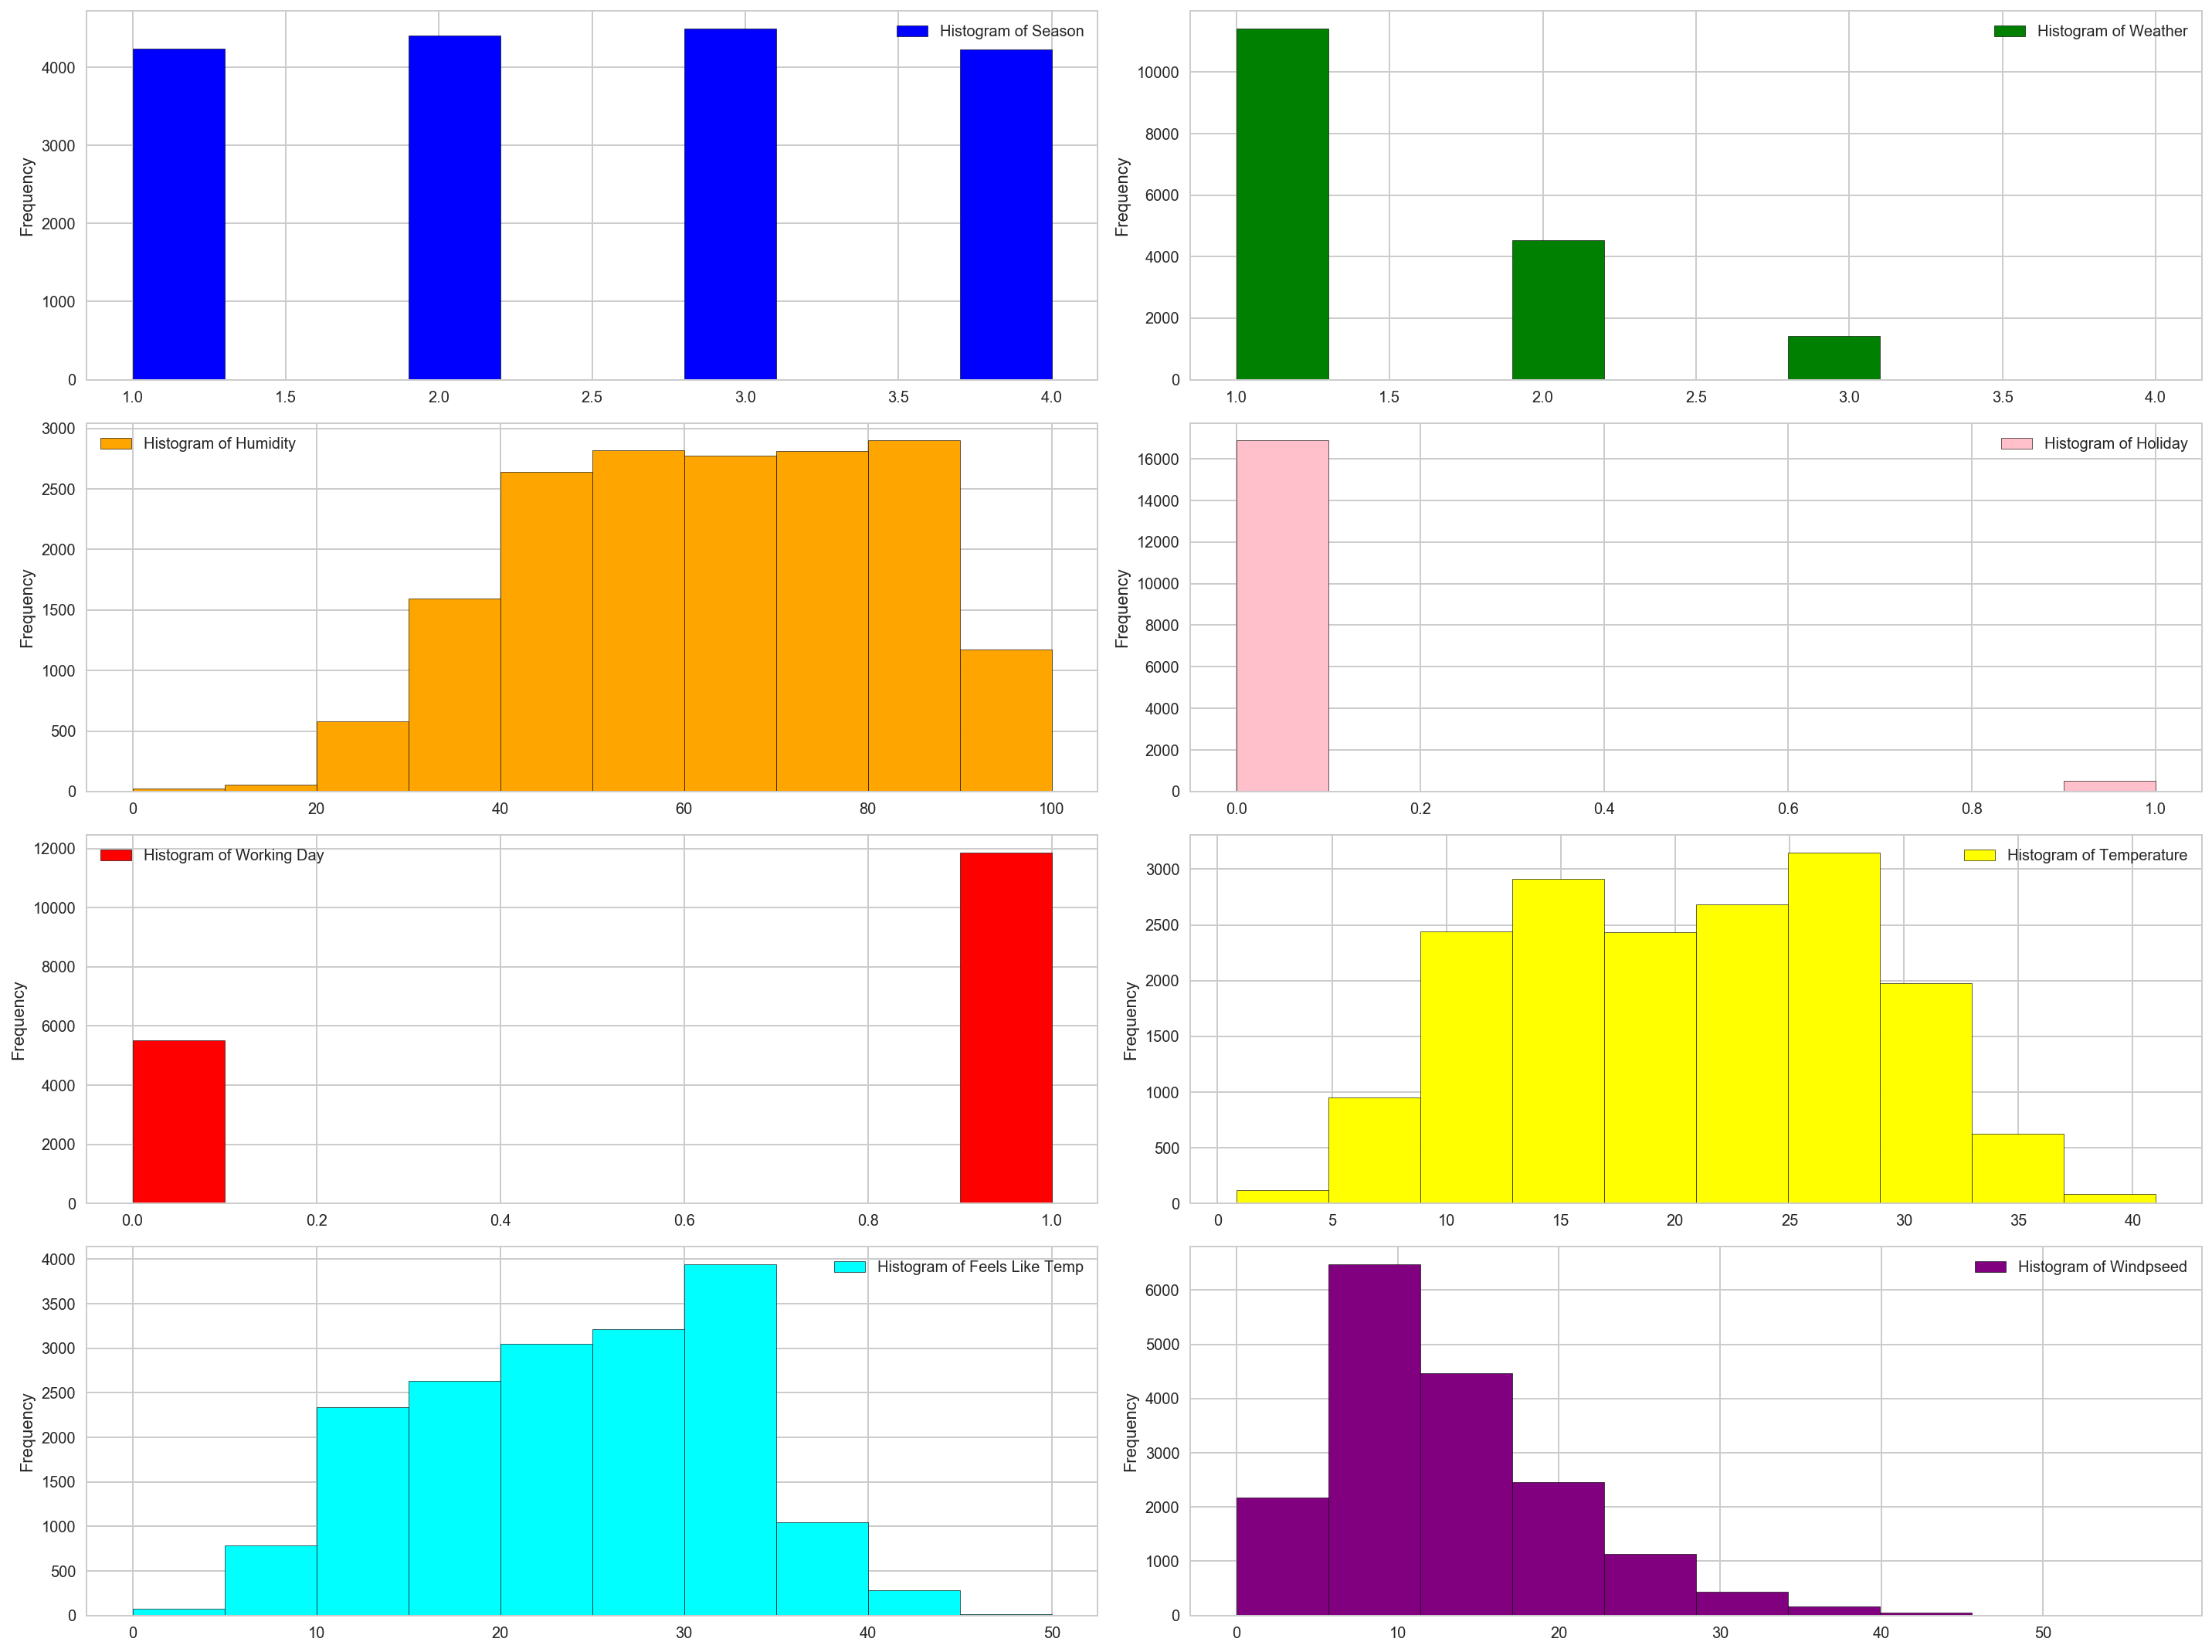

In [12]:
plt.figure(figsize=(20,15))
plt.subplot(421)
all_df['season'].plot.hist(bins=10, color='blue', label='Histogram of Season', edgecolor='black')
plt.legend(loc='best')
plt.subplot(422)
all_df['weather'].plot.hist(bins=10, color='green', label='Histogram of Weather', edgecolor='black')
plt.legend(loc='best')
plt.subplot(423)
all_df['humidity'].plot.hist(bins=10, color='orange', label='Histogram of Humidity', edgecolor='black')
plt.legend(loc='best')
plt.subplot(424)
all_df['holiday'].plot.hist(bins=10, color='pink', label='Histogram of Holiday', edgecolor='black')
plt.legend(loc='best')
plt.subplot(425)
all_df['workingday'].plot.hist(bins=10, color='red', label='Histogram of Working Day', edgecolor='black')
plt.legend(loc='best')
plt.subplot(426)
all_df['temp'].plot.hist(bins=10, color='yellow', label='Histogram of Temperature', edgecolor='black')
plt.legend(loc='best')
plt.subplot(427)
all_df['atemp'].plot.hist(bins=10, color='cyan', label='Histogram of Feels Like Temp', edgecolor='black')
plt.legend(loc='best')
plt.subplot(428)
all_df['windspeed'].plot.hist(bins=10, color='purple', label='Histogram of Windpseed', edgecolor='black')
plt.legend(loc='best')
plt.tight_layout();

Few inferences can be drawn by looking at the these histograms:
- Season has four categories of almost equal distribution
- Weather 1 has higher contribution i.e. mostly clear weather.
- As expected, mostly working days and variable holiday is also showing a similar inference. You can use the code above to look at the distribution in detail. Here you can generate a variable for weekday using holiday and working day. Incase, if both have zero values, then it must be a working day.
- Variables temp, atemp, humidity and windspeed  looks naturally distributed.

In [13]:
# logarithmic transformation of dependent cols
# (adding 1 first so that 0 values don't become -inf)
for col in ['casual', 'registered', 'count']:
    all_df['%s_log' % col] = np.log(all_df[col] + 1)

In [14]:
all_df['date'] = dt.date
all_df['day'] = dt.day
all_df['month'] = dt.month
all_df['year'] = dt.year
all_df['hour'] = dt.hour
all_df['dow'] = dt.dayofweek
all_df['woy'] = dt.weekofyear

In [15]:
# How many columns have null values
all_df.isnull().sum()

atemp             0
casual            0
count             0
data_set          0
datetime          0
holiday           0
humidity          0
registered        0
season            0
temp              0
weather           0
windspeed         0
workingday        0
casual_log        0
registered_log    0
count_log         0
date              0
day               0
month             0
year              0
hour              0
dow               0
woy               0
dtype: int64

In [16]:
# interpolate weather, temp, atemp, humidity, windspeed
all_df["weather"] = all_df["weather"].interpolate(method='time').apply(np.round)
all_df["temp"] = all_df["temp"].interpolate(method='time')
all_df["atemp"] = all_df["atemp"].interpolate(method='time')
all_df["humidity"] = all_df["humidity"].interpolate(method='time').apply(np.round)
all_df["windspeed"] = all_df["windspeed"].interpolate(method='time')

In [17]:
# add a count_season column using join
by_season = all_df[all_df['data_set'] == 'train'].copy().groupby(['season'])[['count']].agg(sum)
by_season.columns = ['count_season']
all_df = all_df.join(by_season, on='season')

In [18]:
print(by_season)

        count_season
season              
1             312498
2             588282
3             640662
4             544034


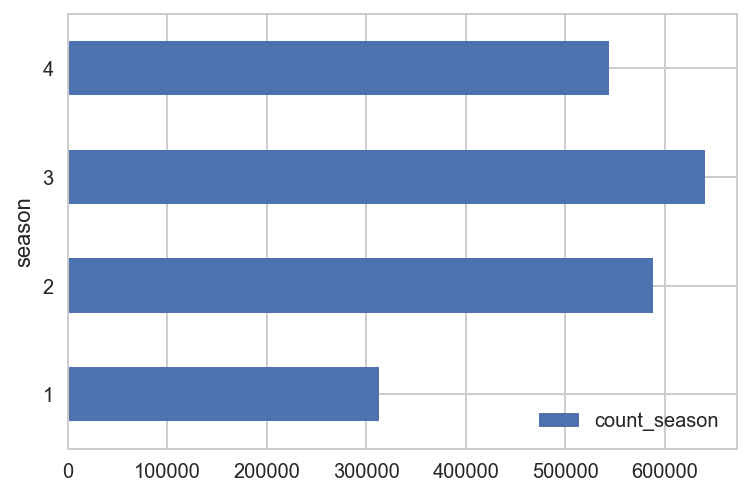

In [19]:
by_season.plot(kind='barh')
plt.grid(True)
plt.show();

In [20]:
def get_day(day_start):
    day_end = day_start + pd.offsets.DateOffset(hours=23)
    return pd.date_range(day_start, day_end, freq="H")

# tax day
all_df.loc[get_day(pd.datetime(2011, 4, 15)), "workingday"] = 1
all_df.loc[get_day(pd.datetime(2012, 4, 16)), "workingday"] = 1

# thanksgiving friday
all_df.loc[get_day(pd.datetime(2011, 11, 25)), "workingday"] = 0
all_df.loc[get_day(pd.datetime(2012, 11, 23)), "workingday"] = 0

# tax day
all_df.loc[get_day(pd.datetime(2011, 4, 15)), "holiday"] = 0
all_df.loc[get_day(pd.datetime(2012, 4, 16)), "holiday"] = 0

# thanksgiving friday
all_df.loc[get_day(pd.datetime(2011, 11, 25)), "holiday"] = 1
all_df.loc[get_day(pd.datetime(2012, 11, 23)), "holiday"] = 1

#storms
all_df.loc[get_day(pd.datetime(2012, 5, 21)), "holiday"] = 1

#tornado
all_df.loc[get_day(pd.datetime(2012, 6, 1)), "holiday"] = 1

In [21]:
by_hour = all_df[all_df['data_set'] == 'train'].copy().groupby(['hour', 'workingday'])['count'].agg('sum').unstack()
by_hour.head(10)

workingday,0,1
hour,,
0,13633,11455
1,10384,4988
2,7654,2605
3,3666,1425
4,1230,1602
5,1280,7655
6,2719,31979
7,6318,90650
8,15380,149680


**Hourly trend:** There must be high demand during office timings. Early morning and late evening can have different trend (cyclist) and low demand during 10:00 pm to 4:00 am.

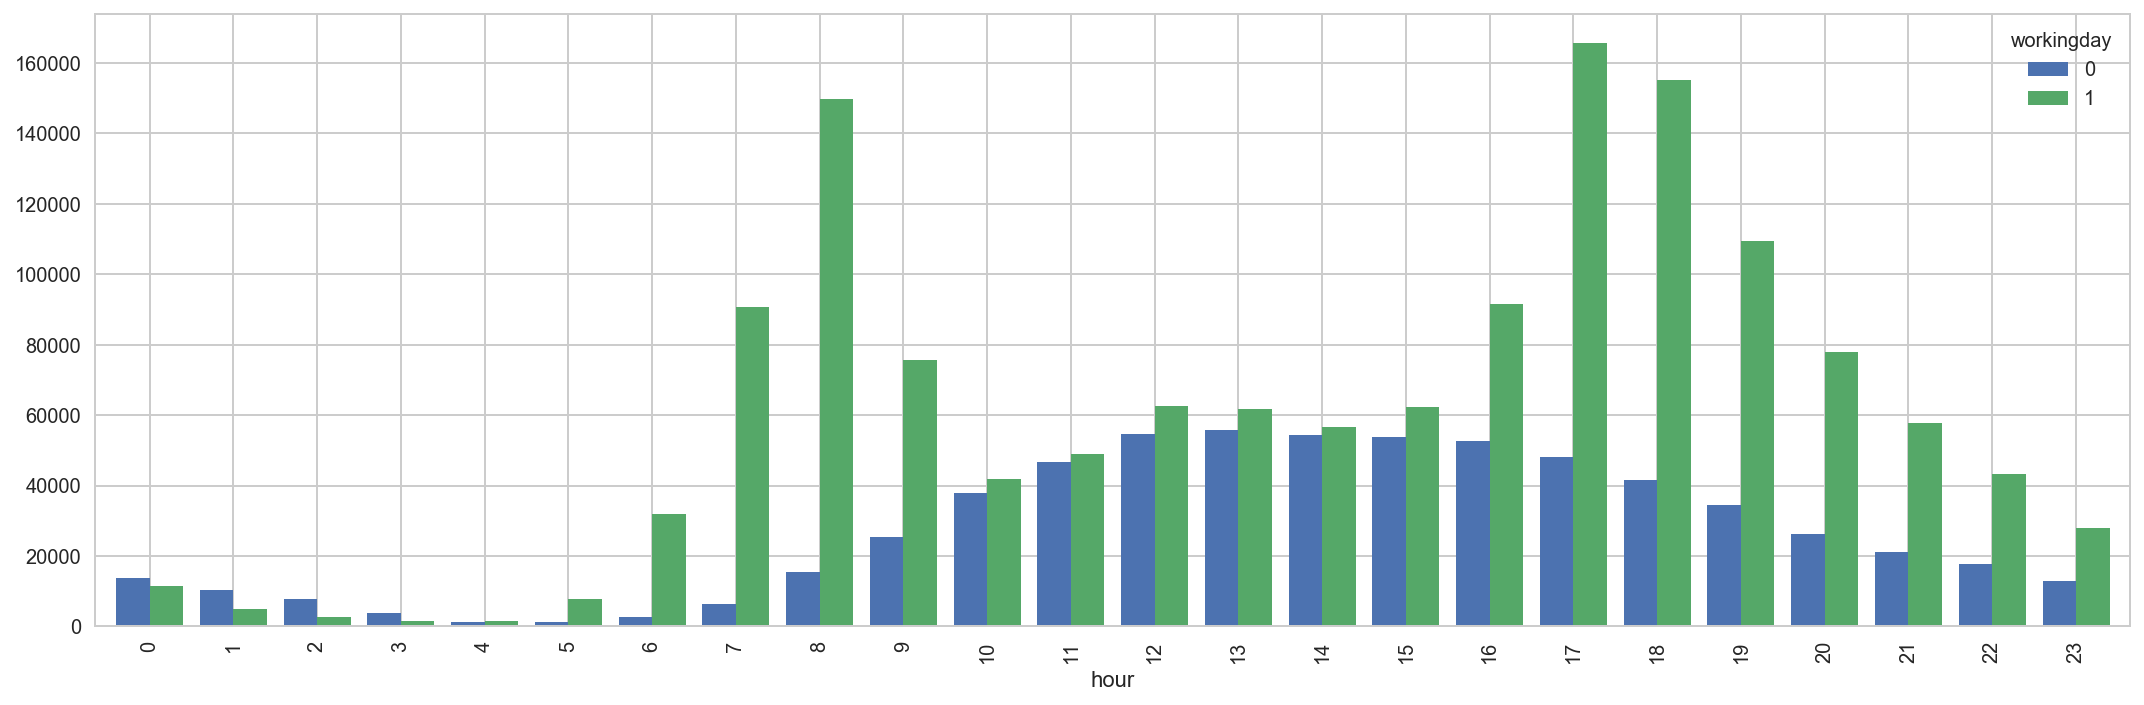

In [22]:
# rentals by hour, split by working day (or not)
by_hour.plot(kind='bar', figsize=(15,5), width=0.8);
plt.grid(True)
plt.tight_layout();

### 4. Hypothesis Testing (using multivariate analysis)

Till now, we have got a fair understanding of the data set. Now, let's test the hypothesis which we had generated earlier.  Here we have added some additional hypothesis from the dataset. Let's test them one by one:

**Hourly trend**: We don't have the variable 'hour' as part of data provides but we extracted it using the datetime column.
Let's plot the hourly trend of count over hours and check if our hypothesis is correct or not. We will separate train and test data set from combined one.

In [23]:
train_df = all_df[all_df['data_set'] == 'train'].copy()

In [24]:
#train_df.boxplot(column='count', by='hour', figsize=(15,5))
#plt.ylabel('Count of Users')
#plt.title("Boxplot of Count grouped by hour")
#plt.suptitle("") # get rid of the pandas autogenerated title

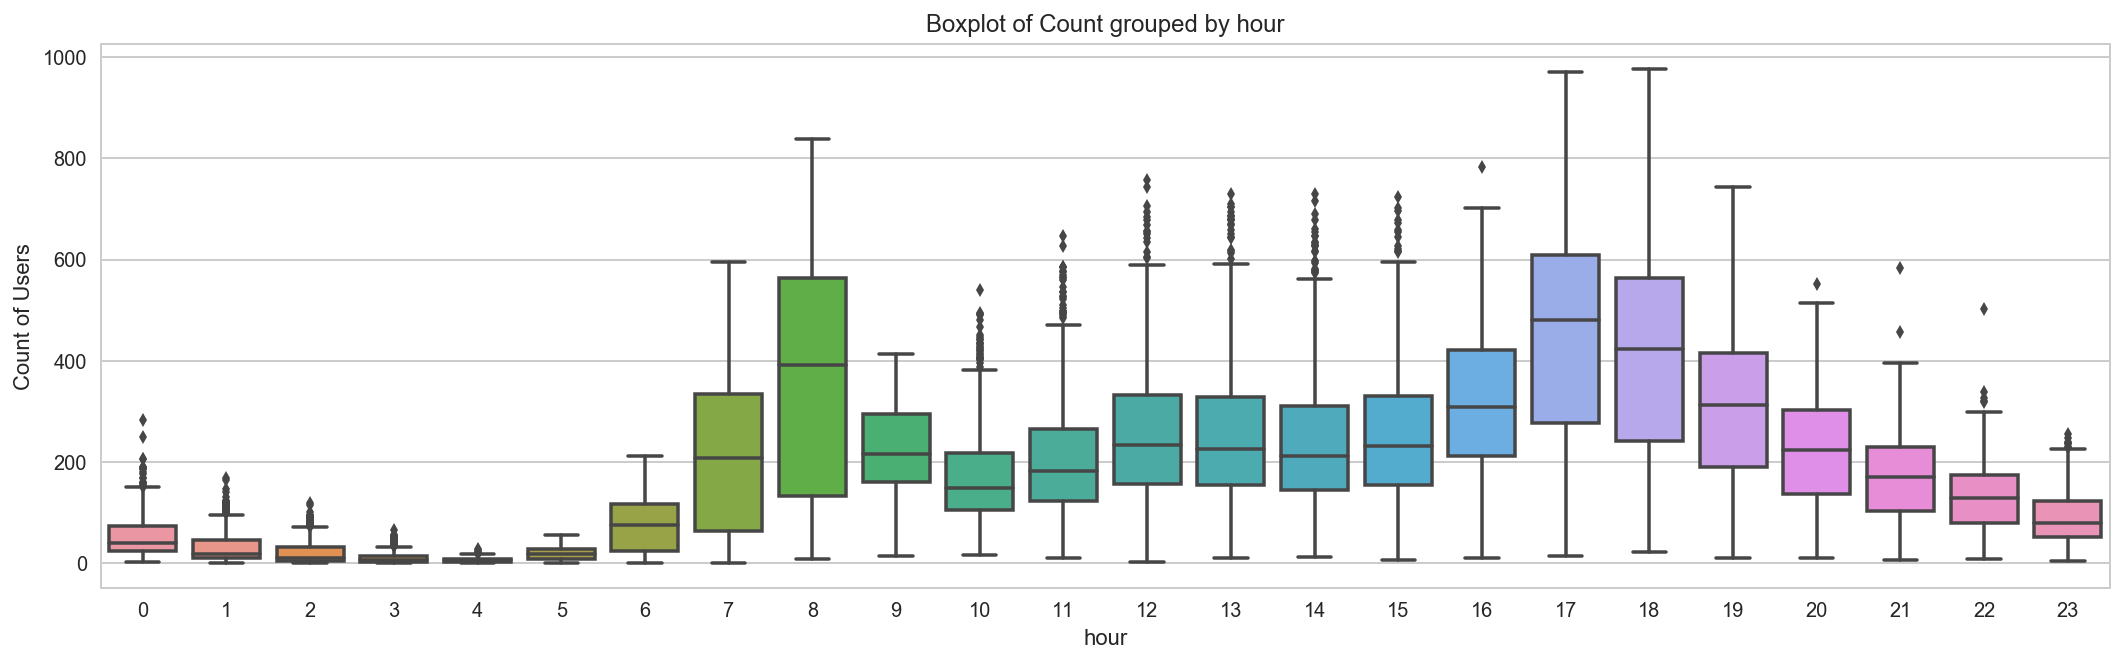

In [25]:
fig, ax = plt.subplots(figsize=(18, 5))
sns.boxplot(x=train_df['hour'], y=train_df['count'], ax=ax)
ax.set_ylabel('Count of Users')
ax.set_title("Boxplot of Count grouped by hour");
#plt.suptitle("") # get rid of the pandas autogenerated title

Above, we can see the trend of bike demand over hours. Quickly, we'll segregate the bike demand in three categories:

- High     : 7-9 and 17-19 hours
- Average  : 10-16 hours
- Low      : 0-6 and 20-24 hours
Here we have analyzed the distribution of total bike demand. 

Let's look at the distribution of registered and casual users separately.

#### Good Weather is most frequent in Fall<sup>[5]</sup>

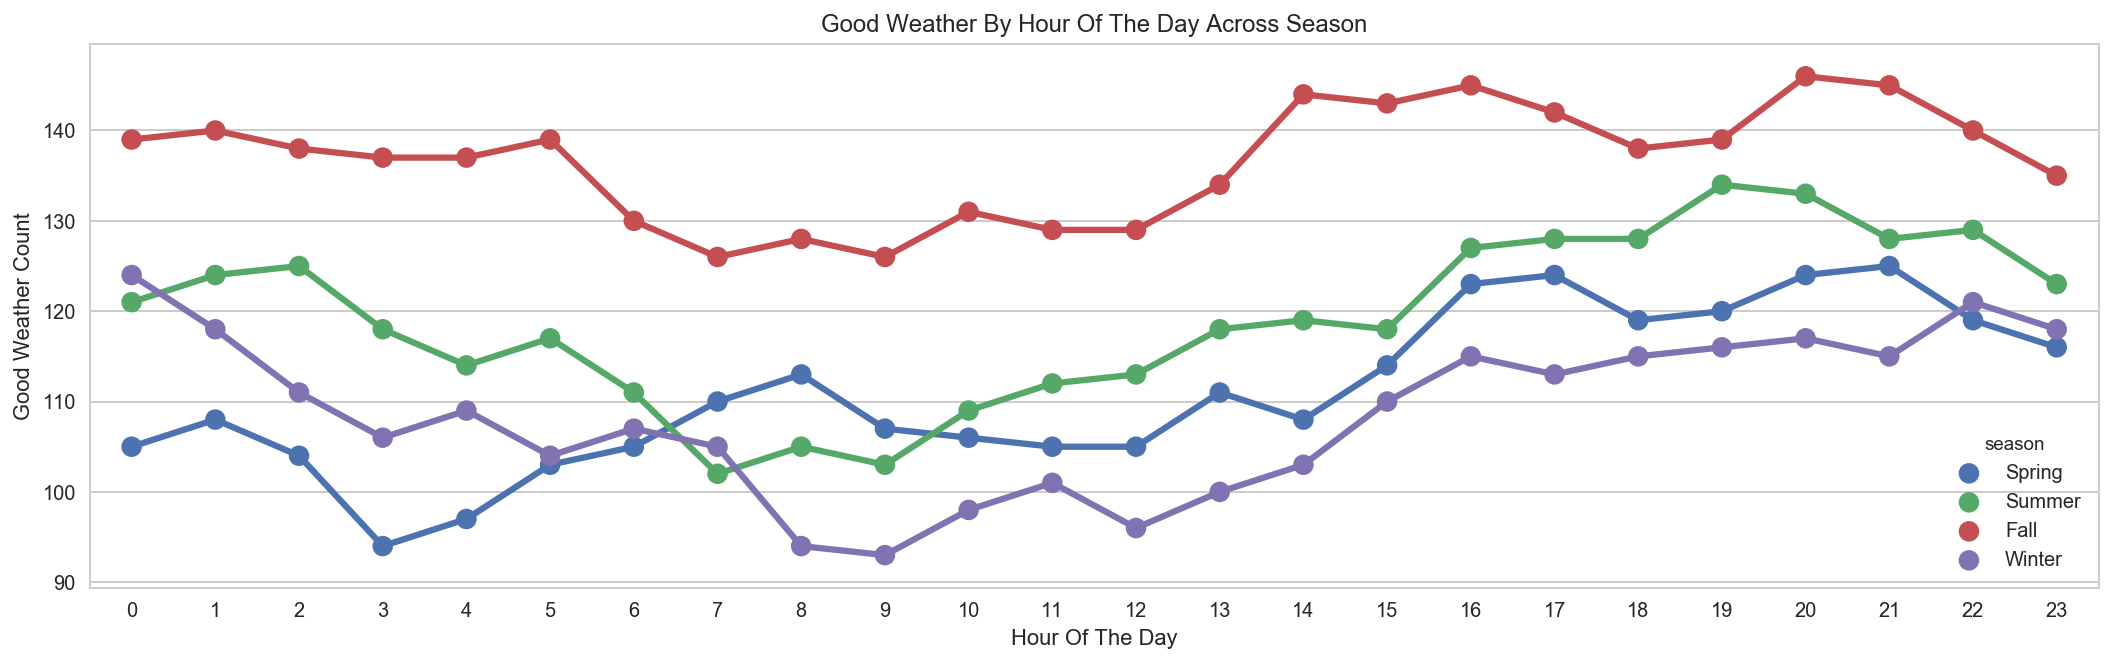

In [26]:
season_map = {1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'}
good_weather = all_df[all_df['weather'] == 1][['hour', 'season']].copy()
data = pd.DataFrame({'count' : good_weather.groupby(["hour","season"]).size()}).reset_index()
data['season'] = data['season'].map(lambda d : season_map[d])

fig, ax = plt.subplots(figsize=(18, 5))
sns.pointplot(x=data["hour"], y=data["count"], hue=data["season"], ax=ax)
ax.set(xlabel='Hour Of The Day', ylabel='Good Weather Count', title="Good Weather By Hour Of The Day Across Season");

#### Normal Weather happens most frequent in Spring<sup>[5]</sup>

In [27]:
season_map = {1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'}
normal_weather = all_df[all_df['weather'] == 3][['hour', 'season']].copy()
data = pd.DataFrame({'count' : normal_weather.groupby(["hour","season"]).size()}).reset_index()
data['season'] = data['season'].map(lambda d : season_map[d])

In [28]:
data.sample(n=5)

,hour,season,count
45,11,Summer,8
57,14,Summer,19
73,18,Summer,19
10,2,Fall,11
76,19,Spring,16


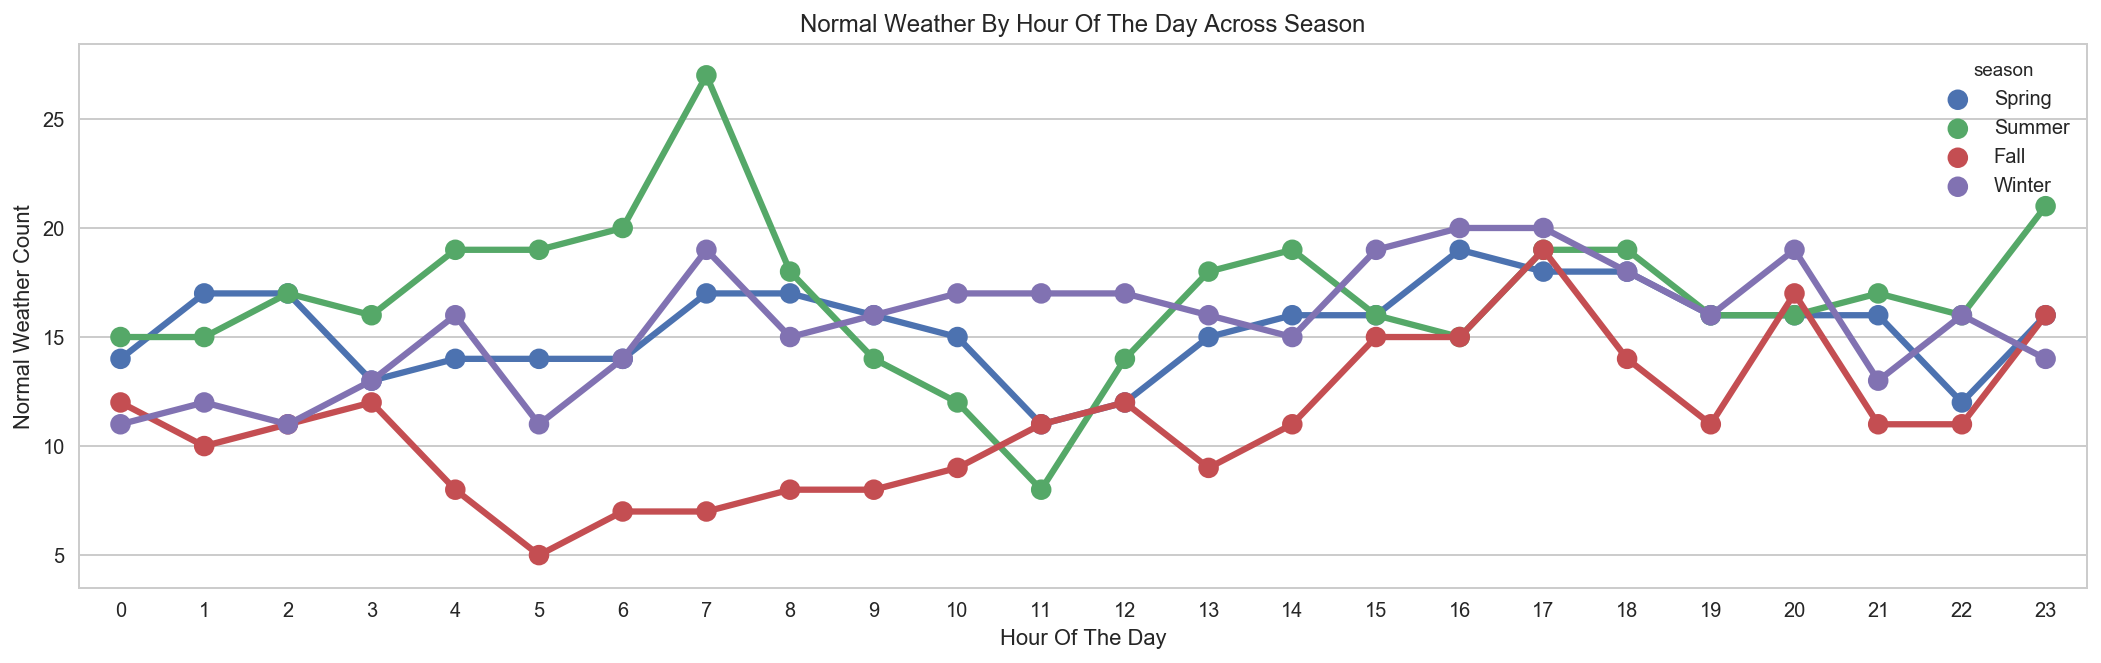

In [29]:
fig, ax = plt.subplots(figsize=(18, 5))
sns.pointplot(x=data["hour"], y=data["count"], hue=data["season"], ax=ax)
ax.set(xlabel='Hour Of The Day', ylabel='Normal Weather Count', title="Normal Weather By Hour Of The Day Across Season");

In [30]:
data = pd.pivot_table(data, values='count', columns='season', index='hour')
data.sample(5)

season,Fall,Spring,Summer,Winter
hour,,,,
7,7,17,27,19
15,15,16,16,19
21,11,16,17,13
20,17,16,16,19
1,10,17,15,12


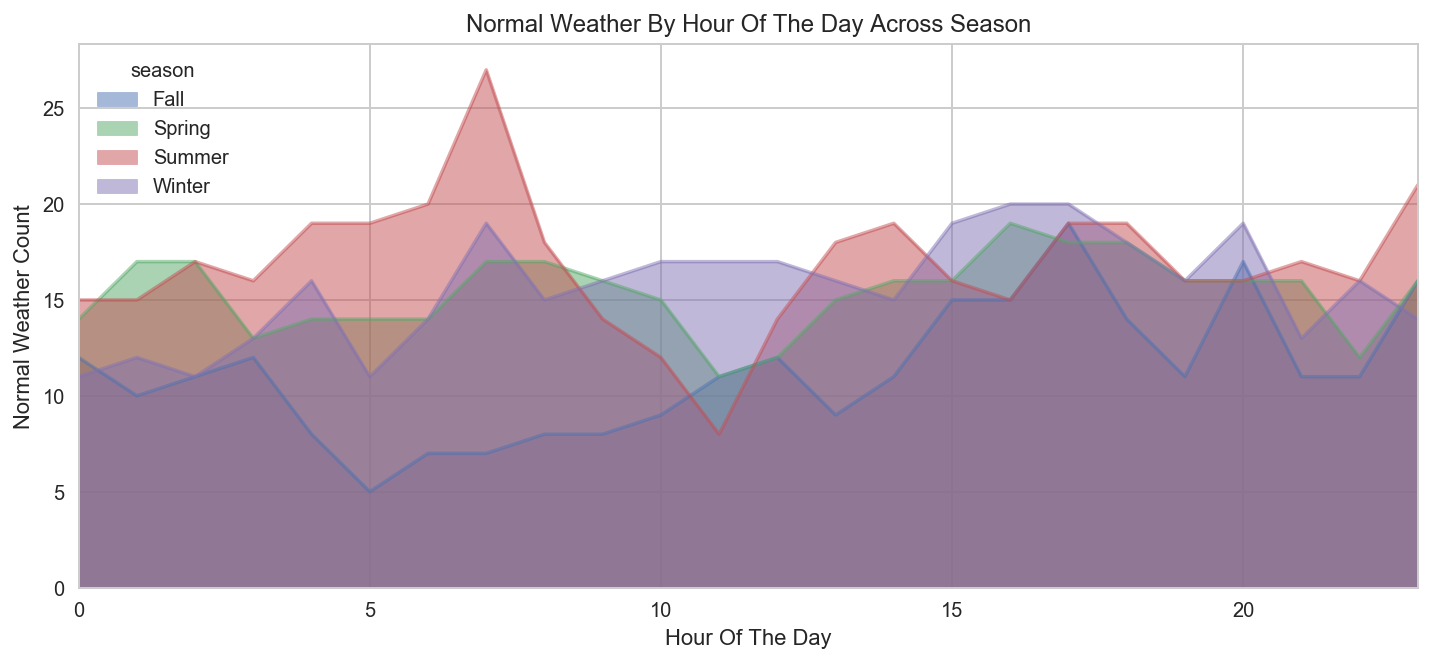

In [31]:
fig, ax = plt.subplots(figsize=(12, 5))
data.plot.area(stacked=False, ax=ax)
ax.set(xlabel='Hour Of The Day', ylabel='Normal Weather Count', title="Normal Weather By Hour Of The Day Across Season");

#### Bad Weather happens most frequent in Summer & Winter<sup>[5]</sup>

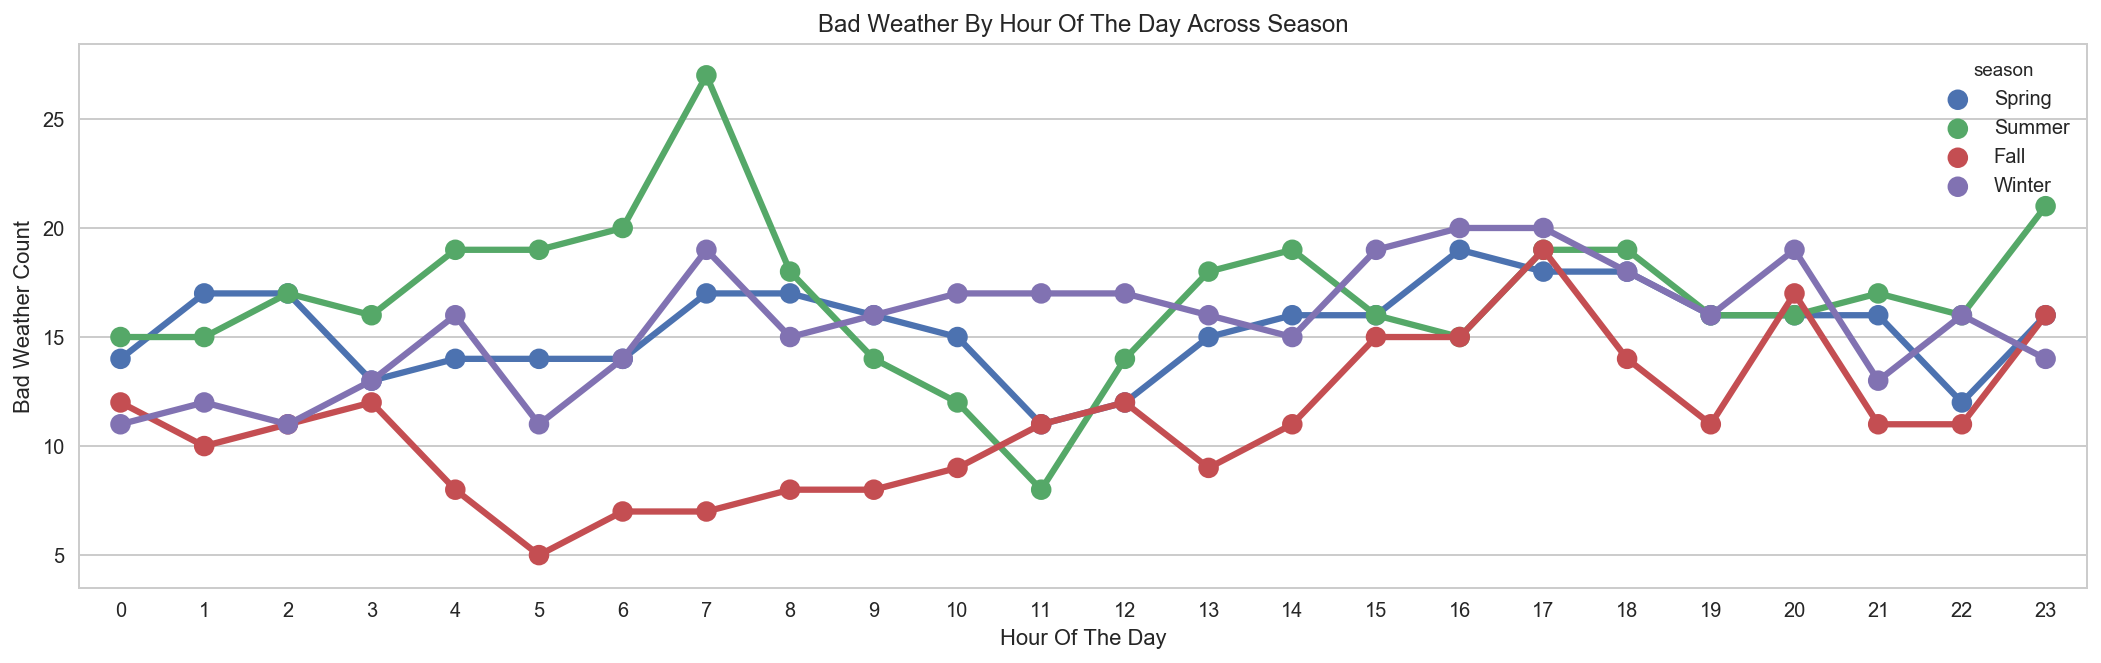

In [32]:
season_map = {1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'}
bad_weather = all_df[all_df['weather'] == 3][['hour', 'season']].copy()
data = pd.DataFrame({'count' : bad_weather.groupby(["hour","season"]).size()}).reset_index()
data['season'] = data['season'].map(lambda d : season_map[d])

fig, ax = plt.subplots(figsize=(18, 5))
sns.pointplot(x=data["hour"], y=data["count"], hue=data["season"], ax=ax)
ax.set(xlabel='Hour Of The Day', ylabel='Bad Weather Count', title="Bad Weather By Hour Of The Day Across Season");

#### Bikes are rented more in Good Weather and much less in Bad Weather

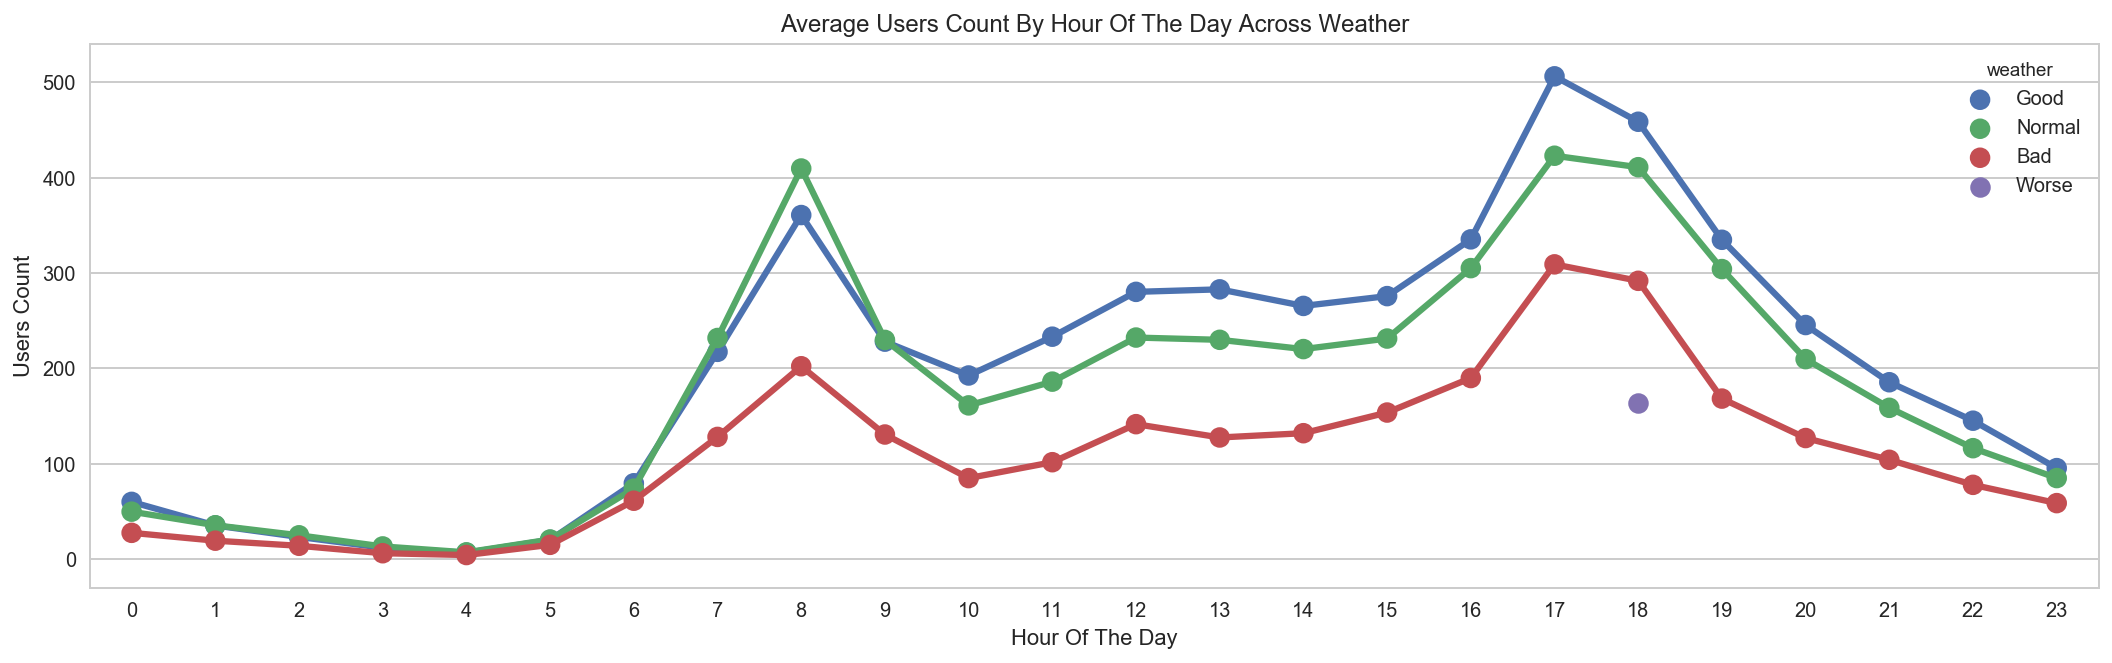

In [33]:
weather_map = {1:'Good', 2:'Normal', 3:'Bad', 4:'Worse'}
data = pd.DataFrame(train_df.groupby(["hour","weather"], sort=True)["count"].mean()).reset_index()
data['weather'] = data['weather'].map(lambda d : weather_map[d])
fig, ax = plt.subplots(figsize=(18, 5))
sns.pointplot(x=data["hour"], y=data["count"], hue=data["weather"], ax=ax)
ax.set(xlabel='Hour Of The Day', ylabel='Users Count', title="Average Users Count By Hour Of The Day Across Weather");

#### Bikes are rented more in Fall and much less in Spring

In [34]:
season_map = {1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'}
data = pd.DataFrame({'mean':train_df.groupby(["hour","season"], sort=True)["count"].mean()}).reset_index()
data['season'] = data['season'].map(lambda d : season_map[d])

In [35]:
data.sample(n=5)

,hour,season,mean
56,14,Spring,151.263158
53,13,Summer,289.991228
66,16,Fall,371.324561
13,3,Summer,11.714286
0,0,Spring,28.292035


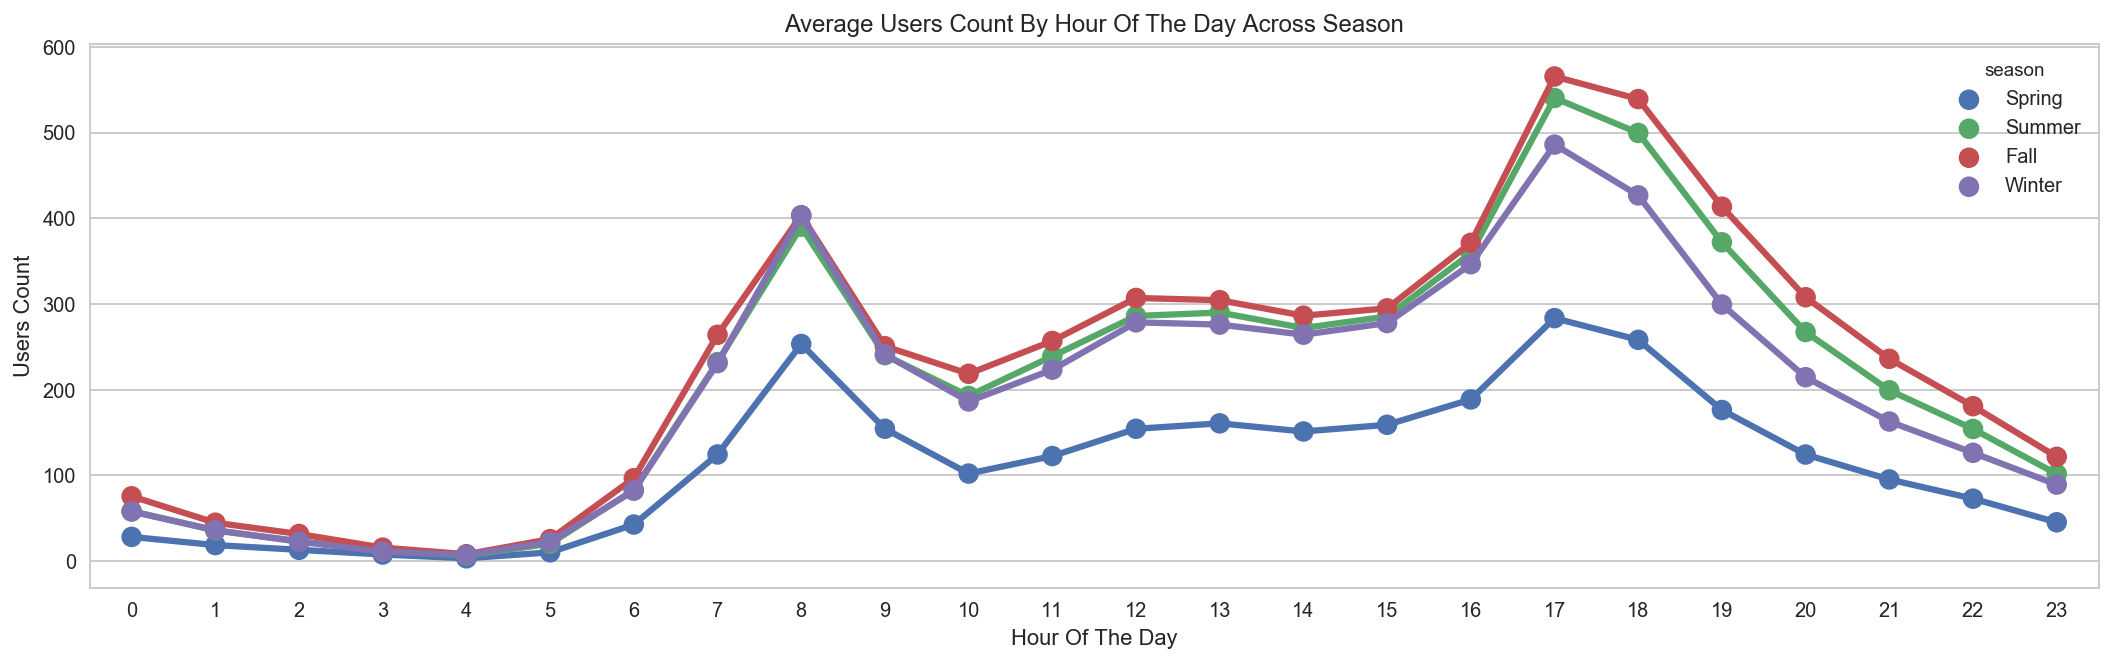

In [36]:
fig, ax = plt.subplots(figsize=(18, 5))
sns.pointplot(x=data["hour"], y=data["mean"], hue=data["season"], ax=ax)
ax.set(xlabel='Hour Of The Day', ylabel='Users Count', title="Average Users Count By Hour Of The Day Across Season");

#### Bikes are rented mostly for Morning/Evening commutes on Weekdays, and mostly Daytime rides on Weekends

In [37]:
day_map = {0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
hueOrder = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]
data = pd.DataFrame({'mean':train_df.groupby(["hour","dow"], sort=True)["count"].mean()}).reset_index()
data['dow'] = data['dow'].map(lambda d : day_map[d])

In [38]:
data.sample(n=5)

,hour,dow,mean
31,4,Thursday,5.301587
61,8,Saturday,117.560606
102,14,Friday,227.062500
161,23,Monday,66.769231
150,21,Thursday,199.707692


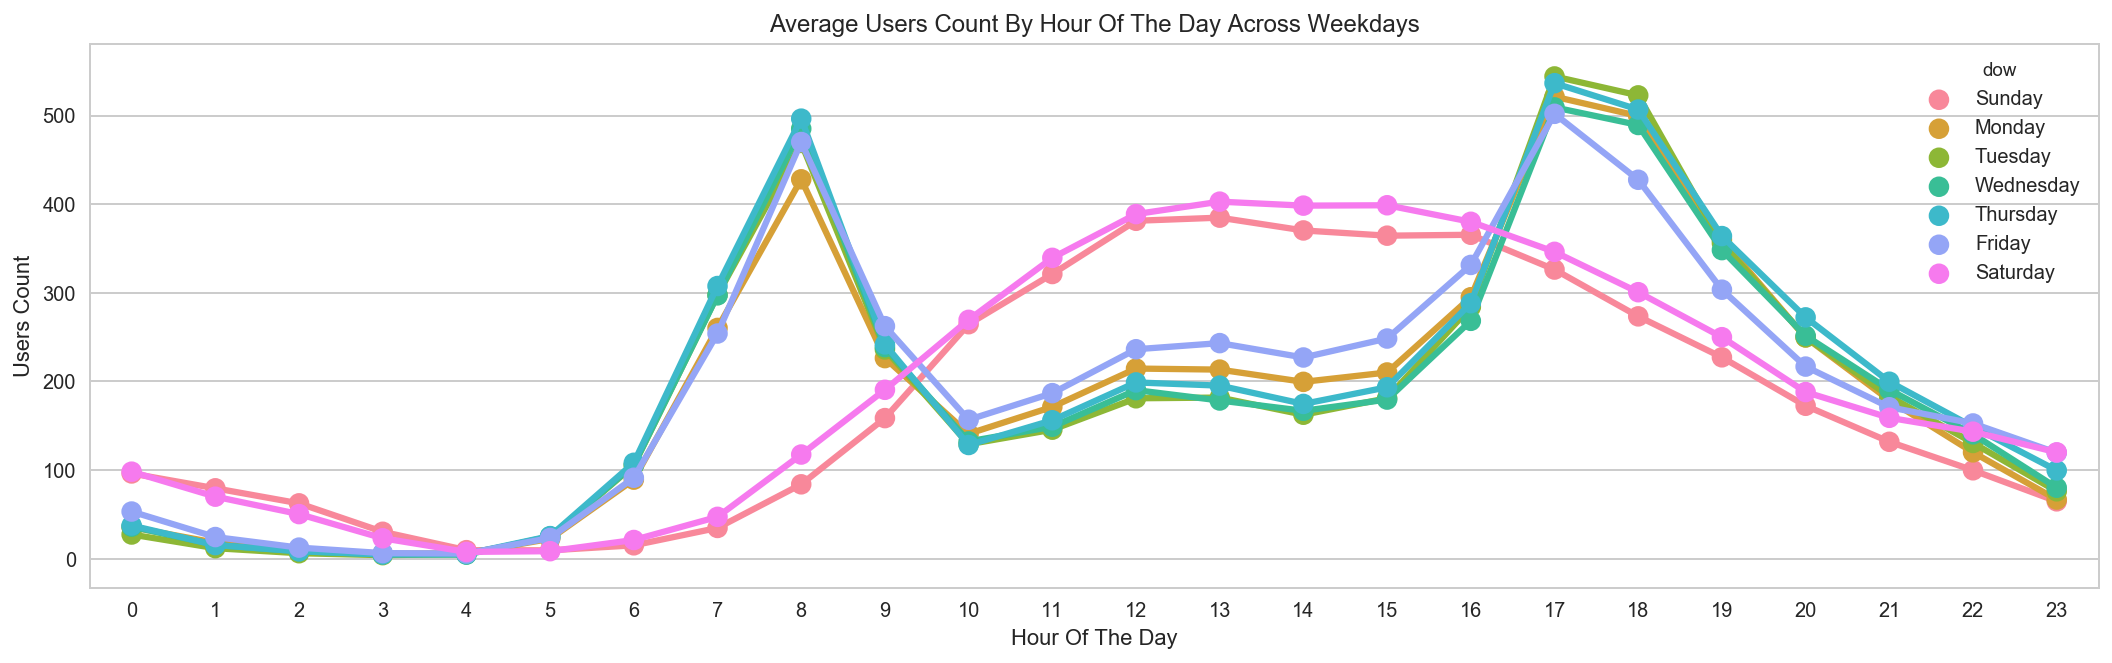

In [39]:
fig, ax = plt.subplots(figsize=(18, 5))
sns.pointplot(x=data["hour"], y=data["mean"], hue=data["dow"], hue_order=hueOrder, ax=ax)
ax.set(xlabel='Hour Of The Day', ylabel='Users Count', title="Average Users Count By Hour Of The Day Across Weekdays");

In [40]:
#fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=False, sharey=False)

#train_df.boxplot(column='casual', by='hour', ax=axs[0])
#axs[0].set_ylabel('casual users')
#axs[0].set_title('')

#train_df.boxplot(column='registered', by='hour', ax=axs[1])
#axs[1].set_ylabel('registered users')
#axs[1].set_title('')

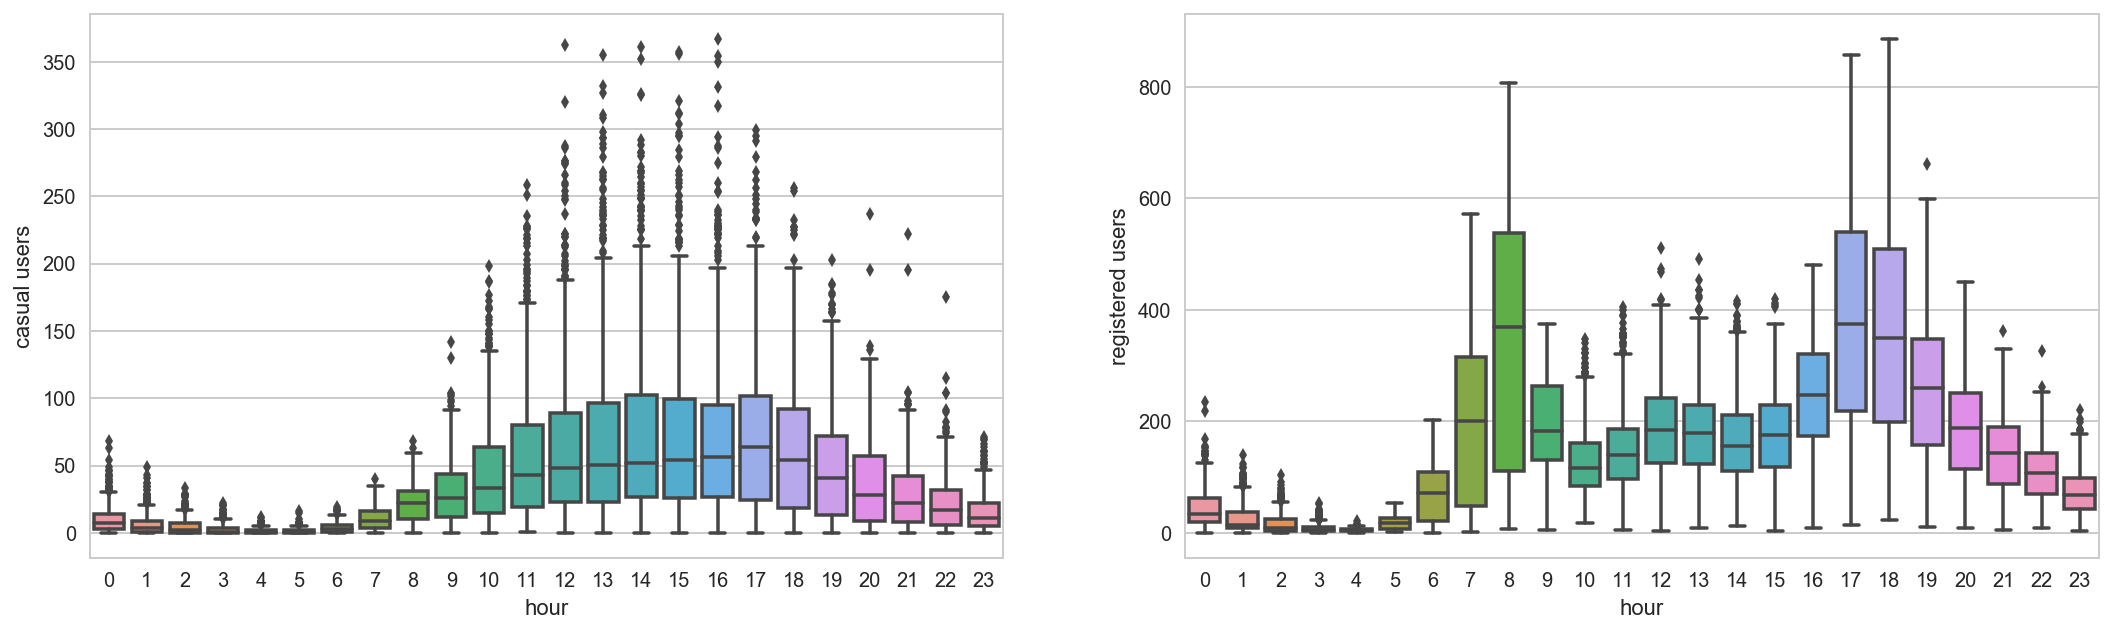

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(18,5), sharex=False, sharey=False)

sns.boxplot(x='hour', y='casual', data=train_df, ax=axs[0])
axs[0].set_ylabel('casual users')
axs[0].set_title('')

sns.boxplot(x='hour', y='registered', data=train_df, ax=axs[1])
axs[1].set_ylabel('registered users')
axs[1].set_title('');

In [42]:
train_df[["hour","casual","registered"]].head(5)

,hour,casual,registered
datetime,,,
2011-01-01 00:00:00,0,3,13
2011-01-01 01:00:00,1,8,32
2011-01-01 02:00:00,2,5,27
2011-01-01 03:00:00,3,3,10
2011-01-01 04:00:00,4,0,1


In [43]:
pd.melt(train_df[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'], var_name='usertype', value_name='count').head(5)

,hour,usertype,count
0,0,casual,3
1,1,casual,8
2,2,casual,5
3,3,casual,3
4,4,casual,0


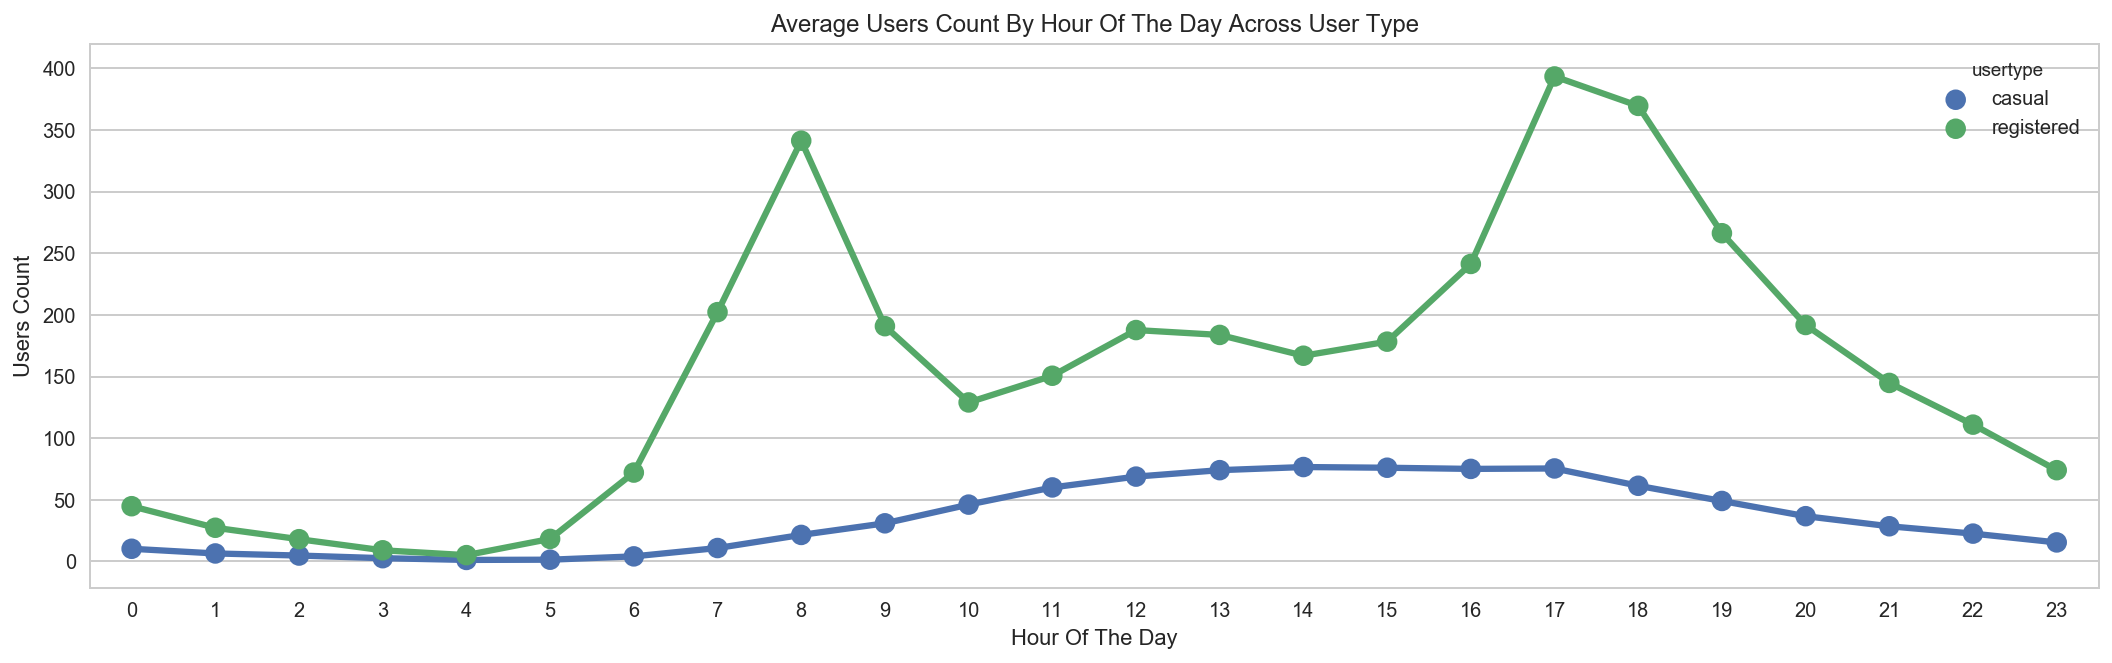

In [44]:
fig, ax = plt.subplots(figsize=(18, 5))
train_df_melt = pd.melt(train_df[["hour","casual","registered"]], id_vars=['hour'], value_vars=['casual', 'registered'], var_name='usertype', value_name='count')
data = pd.DataFrame(train_df_melt.groupby(["hour", "usertype"], sort=True)["count"].mean()).reset_index()
sns.pointplot(x=data["hour"], y=data["count"], hue=data["usertype"], hue_order=["casual","registered"], ax=ax)
ax.set(xlabel='Hour Of The Day', ylabel='Users Count', title='Average Users Count By Hour Of The Day Across User Type');

Above we can see that registered users have similar trend as count. Whereas, casual users have different trend. Thus, we can say that 'hour' is significant variable and our hypothesis is 'true'.

We can notice that there are a lot of outliers while plotting the count of registered and casual users. These values are not generated due to error, so we consider them as natural outliers. They might be a result of groups of people taking up cycling (who are not registered). To treat such outliers, we will use logarithm transformation. Let's look at the similar plot after log transformation.

#### On Workdays most Bikes are rented on Warm Mornings and Evenings<sup>[2]</sup>

<sup>[4]</sup>When graphing a categorical variable vs. a continuous variable, it can be useful to create a scatter plot to visually examine distributions. Together with a box plot, it will allow us to see the distributions of our variables. Unfortunately, if our points occur close together, we will get a very uninformative smear. One way of making the scatter plot work is by adding jitter. With the jitter, a random amount is added or subtracted to each of the variables along the categorical axis. Where before, we may have had a categorical value vector that looked something like [1,2,2,2,1,3], post-jitter, they would look something like [1.05, 1.96, 2.05, 2, .97, 2.95]. Each value has had somewhere between [-0.05,0.05] added to it. This then means that when we plot our variables, we'll see a cloud of points that represent our distribution, rather than a long smear.

In [109]:
def hour_jitter(h):
    #return h + ((np.random.randint(low=0, high=9, size=1)[0] - 4) / 10)
    return h + np.random.uniform(-0.4, 0.4)

In [46]:
def hour_format(h):
    return "{:02d}:00 AM".format(h) if h <= 12 else "{:02d}:00 PM".format(h%12)

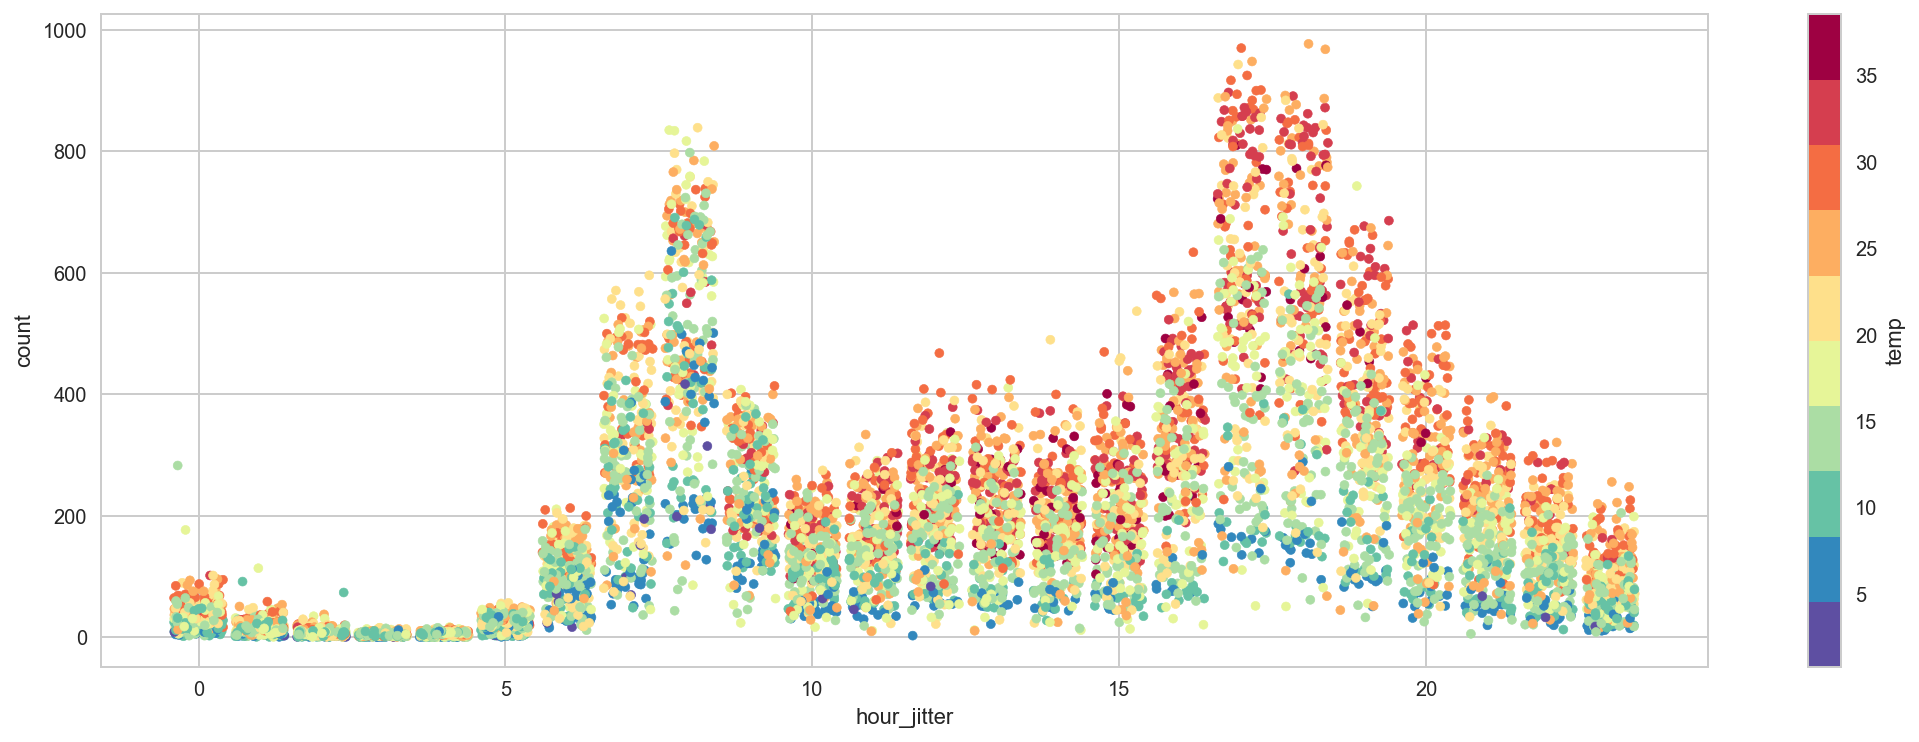

In [110]:
# jitter plot
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# color_map = plt.get_cmap("jet")
color_map = mcolors.ListedColormap(list(["#5e4fa2", "#3288bd", "#66c2a5", "#abdda4", "#e6f598", "#fee08b", "#fdae61", "#f46d43", "#d53e4f", "#9e0142"]))
train_df['hour_jitter'] = train_df['hour'].map(hour_jitter)
train_df[train_df['workingday'] == 1].plot(kind="scatter", x='hour_jitter', y='count',
    figsize=(18,6),
    c='temp', cmap=color_map, colorbar=True,
    sharex=False)

hours = np.unique(train_df['hour'].values)
hour_labels = [hour_format(h) for h in hours]
#plt.xticks(hours, hour_labels, rotation='vertical')
train_df.drop('hour_jitter', axis=1, inplace=True);

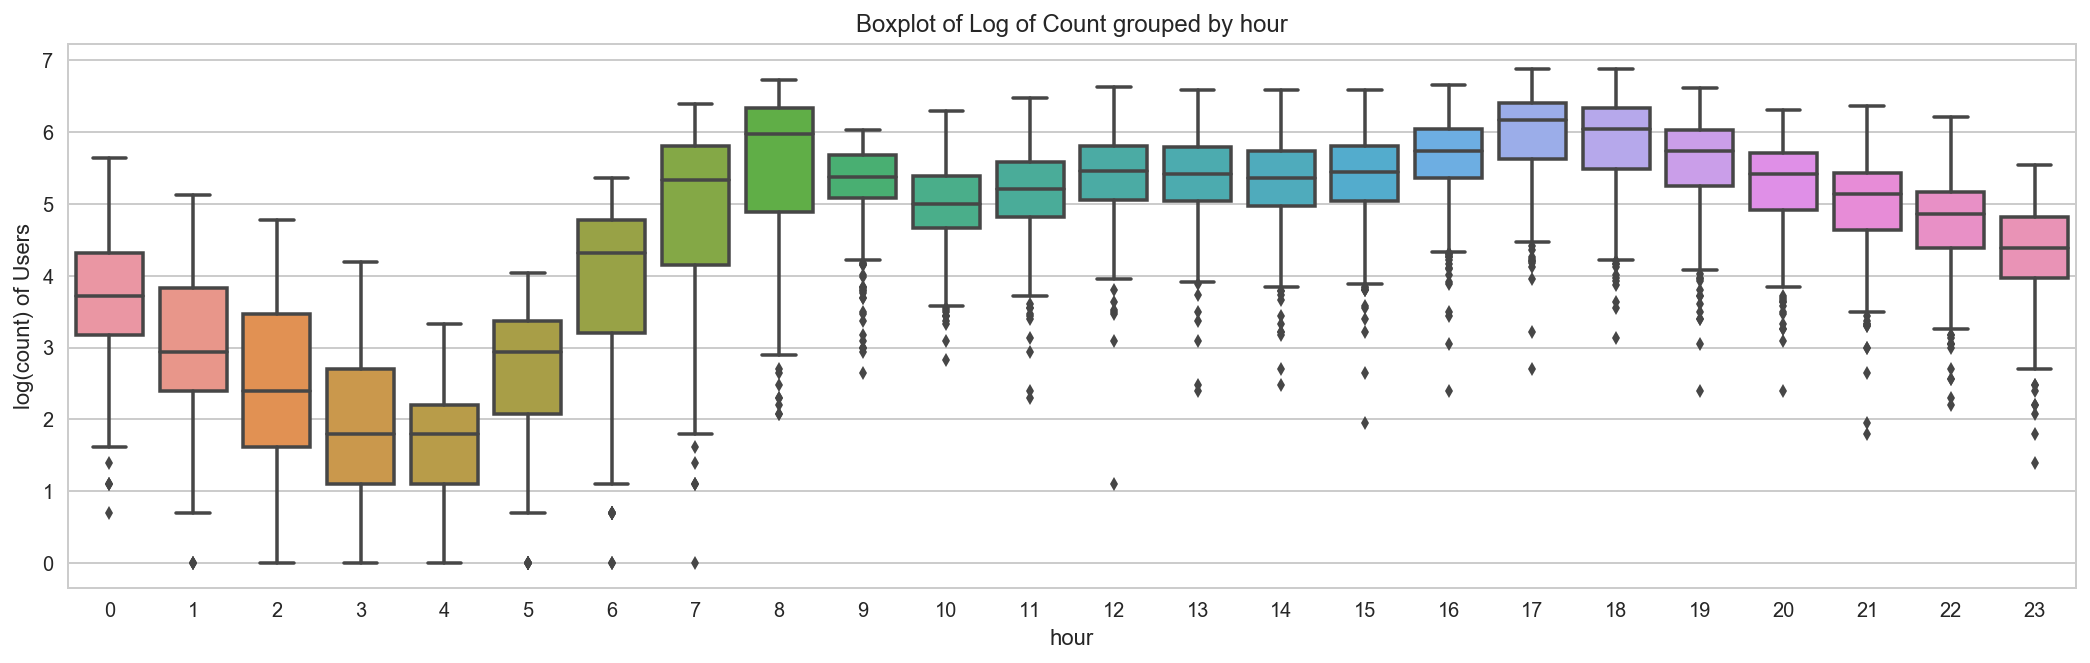

In [48]:
train_df = train_df.assign(log_count = lambda df : np.log(train_df['count']))

fig, ax = plt.subplots(figsize=(18, 5))
sns.boxplot(x='hour', y='log_count', data=train_df, ax=ax)
ax.set(ylabel='log(count) of Users',title='Boxplot of Log of Count grouped by hour')

#plt.suptitle("") # get rid of the pandas autogenerated title
train_df.drop(['log_count'], axis = 1, inplace=True);

**Daily Trend:** Like Hour, we will generate a variable for day from datetime variable and after that we'll plot it.

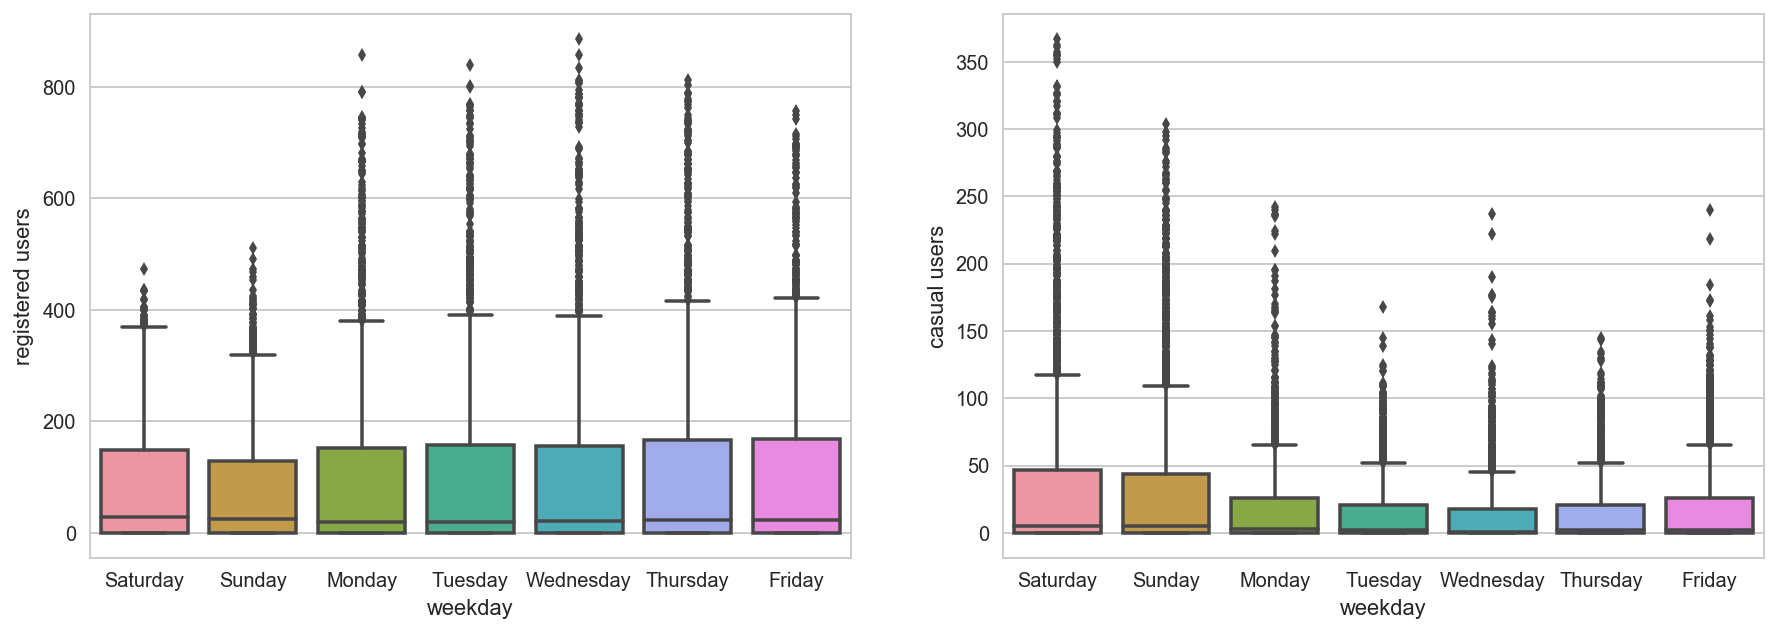

In [49]:
dayOfWeek={0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'}
all_df['weekday'] = all_df['dow'].map(dayOfWeek)

fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=False, sharey=False)

sns.boxplot(x='weekday', y='registered', data=all_df, ax=axs[0])
axs[0].set_ylabel('registered users')
axs[0].set_title('')

sns.boxplot(x='weekday', y='casual', data=all_df, ax=axs[1])
axs[1].set_ylabel('casual users')
axs[1].set_title('')

all_df.drop('weekday', axis=1, inplace=True);

**Rain:** We don’t have the 'rain' variable with us but have 'weather' which is sufficient to test our hypothesis. As per variable description, weather 3 represents light rain and weather 4 represents heavy rain. Take a look at the plot:

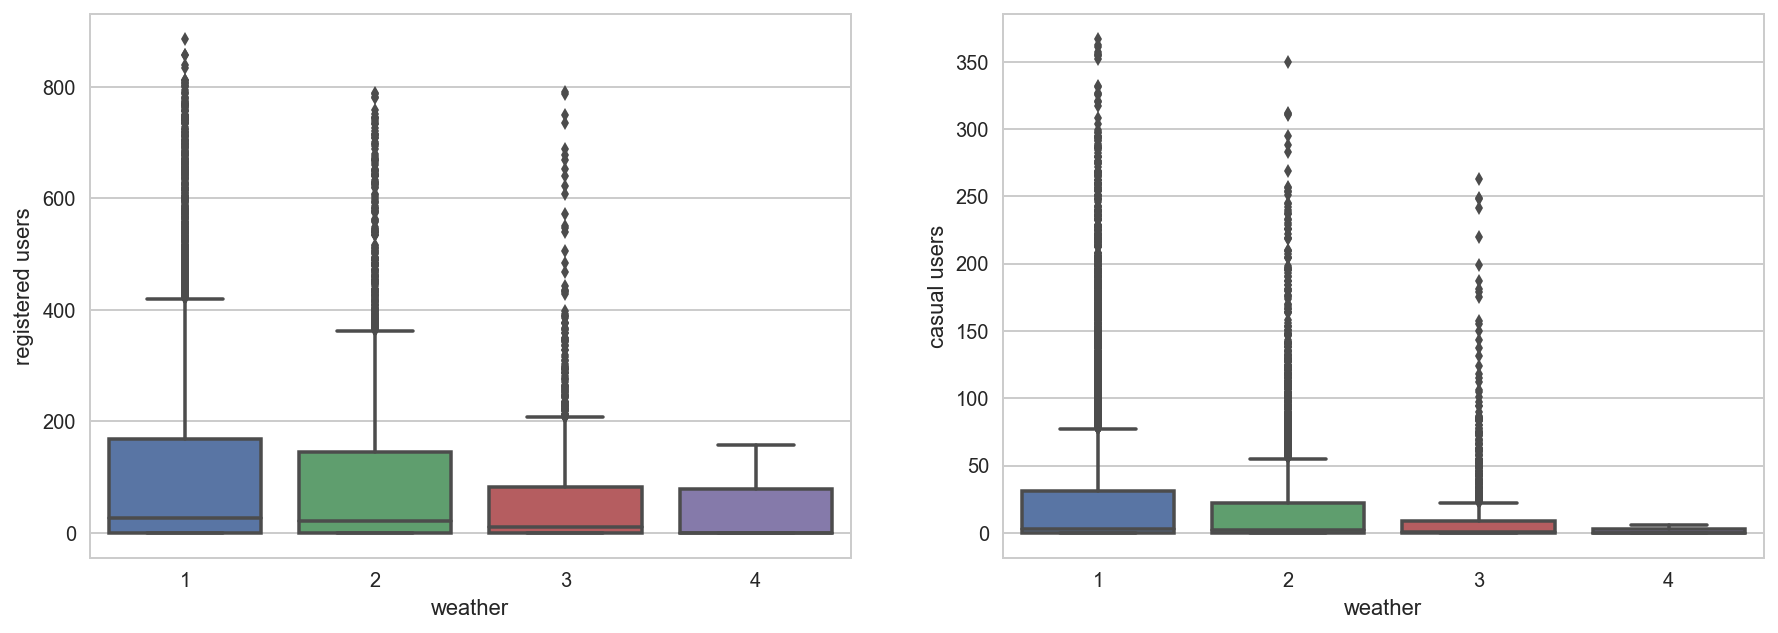

In [50]:
fig, axs = plt.subplots(1, 2, figsize=(15,5), sharex=False, sharey=False)

sns.boxplot(x='weather', y='registered', data=all_df, ax=axs[0])
axs[0].set_ylabel('registered users')
axs[0].set_title('')

sns.boxplot(x='weather', y='casual', data=all_df, ax=axs[1])
axs[1].set_ylabel('casual users')
axs[1].set_title('');

It is clearly satisfying our hypothesis.

**Temperature, Windspeed and Humidity:** These are continuous variables so we can look at the correlation factor to validate hypothesis.

#### Correlation Between Count And Features

In [51]:
sub_df = train_df[['count', 'registered', 'casual', 'temp', 'atemp', 'humidity', 'windspeed', 'workingday', 'holiday']]

In [52]:
sub_df.corr()

,count,registered,casual,temp,atemp,humidity,windspeed,workingday,holiday
count,1.000000,0.970948,0.690414,0.394454,0.389784,-0.317371,0.101369,0.011965,-0.008049
registered,0.970948,1.000000,0.497250,0.318571,0.314635,-0.265458,0.091052,0.120154,-0.023038
casual,0.690414,0.497250,1.000000,0.467097,0.462067,-0.348187,0.092276,-0.319864,0.040464
temp,0.394454,0.318571,0.467097,1.000000,0.984948,-0.064949,-0.017852,0.033174,0.002969
atemp,0.389784,0.314635,0.462067,0.984948,1.000000,-0.043536,-0.057473,0.027851,-0.003455
humidity,-0.317371,-0.265458,-0.348187,-0.064949,-0.043536,1.000000,-0.318607,-0.011039,0.012114
windspeed,0.101369,0.091052,0.092276,-0.017852,-0.057473,-0.318607,1.000000,0.018454,-0.000585
workingday,0.011965,0.120154,-0.319864,0.033174,0.027851,-0.011039,0.018454,1.000000,-0.213189
holiday,-0.008049,-0.023038,0.040464,0.002969,-0.003455,0.012114,-0.000585,-0.213189,1.000000


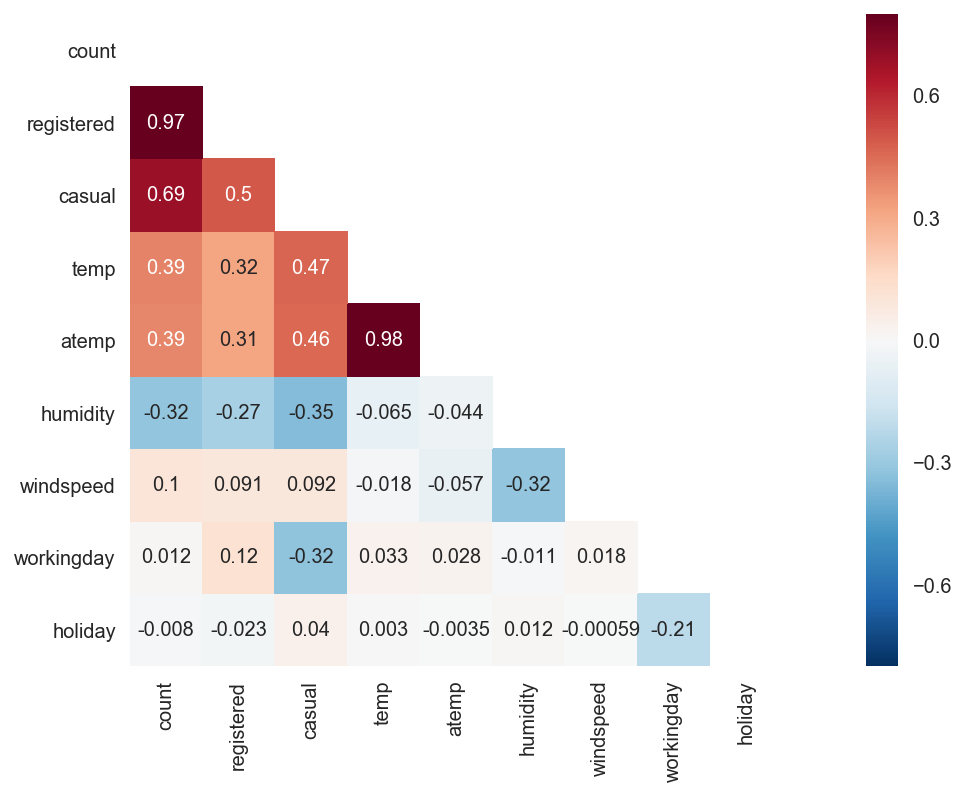

In [53]:
corrMatt = sub_df.corr()
mask = np.zeros_like(corrMatt)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(15, 6))
sns.heatmap(corrMatt, mask=mask, vmax=.8, square=True, annot=True, ax=ax);

Here are a few inferences you can draw by looking at the above histograms:

- Variable temp is positively correlated with dependent variables (casual is more compare to registered)
- Variable atemp is highly correlated with temp.
- Windspeed has lower correlation as compared to temp and humidity

**Time:** Let's extract year of each observation from the datetime column and see the trend of bike demand over year.

#### Distribution of data between Train and Test set based on Season

In [54]:
season_map = {1:'Spring', 2:'Summer', 3:'Fall', 4:'Winter'}
data = all_df[['data_set', 'season']].copy()
data['season'] = data['season'].map(lambda d : season_map[d])

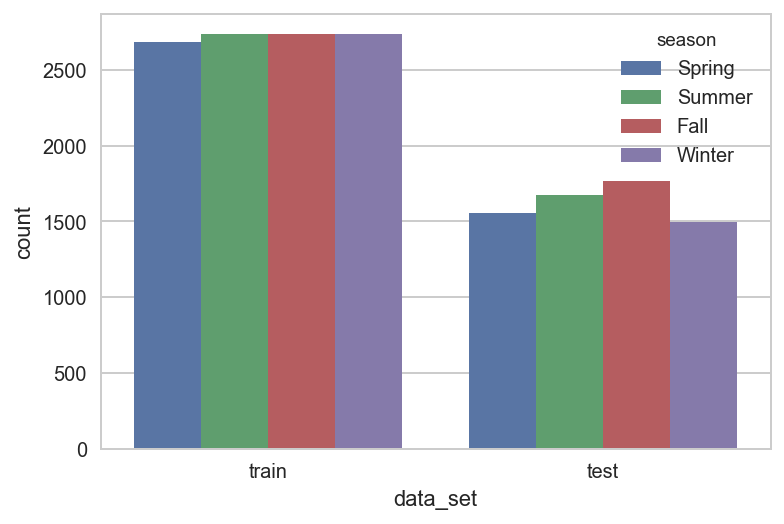

In [55]:
sns.countplot(x="data_set", hue="season", data=data);

#### Distribution of data between Train and Test set based on Weather

In [56]:
weather_map = {1:'Good', 2:'Normal', 3:'Bad', 4:'Worse'}
data = all_df[['data_set', 'weather']].copy()
data['weather'] = data['weather'].map(lambda d : weather_map[d])

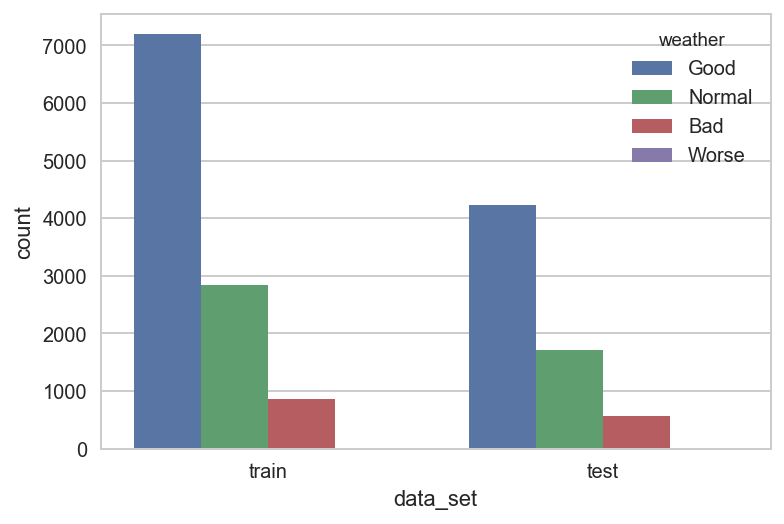

In [57]:
sns.countplot(x="data_set", hue="weather", data=data);

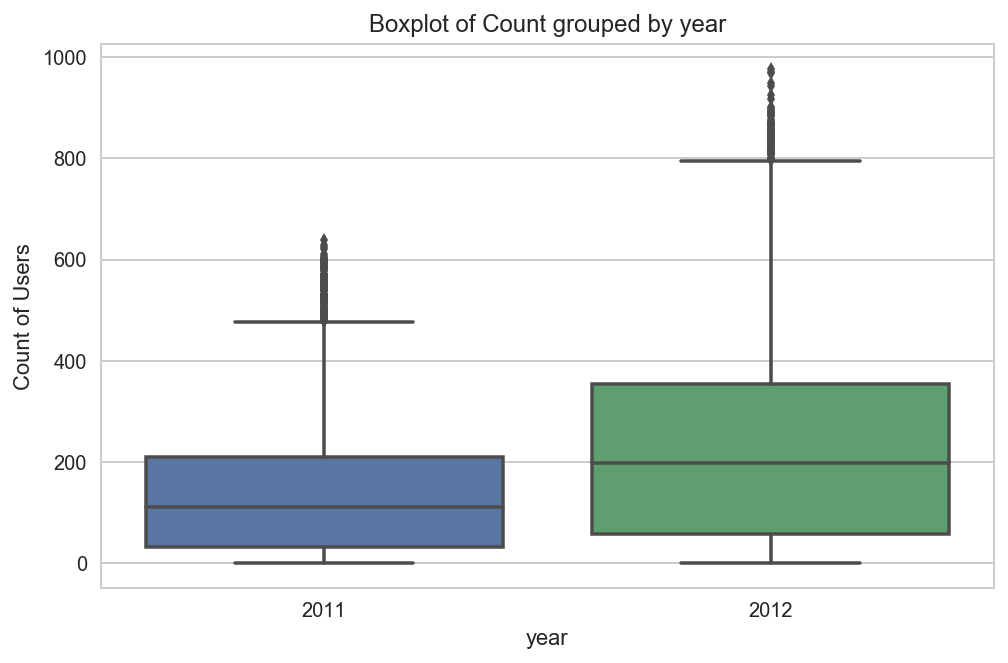

In [58]:
fig, ax = plt.subplots(figsize=(8, 5))
sns.boxplot(x='year', y='count', data=train_df)
ax.set_ylabel('Count of Users')
ax.set_title("Boxplot of Count grouped by year");
#plt.suptitle("") # get rid of the pandas autogenerated title

We can see that 2012 has higher bike demand as compared to 2011.

**Pollution & Traffic:** We don't have the variable related with these metrics in our data set so we cannot test this hypothesis.

### 5. Feature Engineering

In addition to existing independent variables, we will create new variables to improve the prediction power of model. Initially, we have generated new variables like hour, month, day and year.

In [59]:
# feature engineer a new column whether its a peak hour or not
all_df['peak'] = all_df[['hour', 'workingday']]\
    .apply(lambda df: 1 if ((df['workingday'] == 1 and (df['hour'] == 8 or 17 <= df['hour'] <= 18)) \
                            or (df['workingday'] == 0 and 10 <= df['workingday'] <= 19)) else 0, axis = 1)

In [60]:
# sandy
all_df['holiday'] = all_df[['month', 'day', 'holiday', 'year']]\
    .apply(lambda df: 1 if (df['year'] == 2012 and df['month'] == 10 and (df['day'] in [30])) else 0, axis = 1)

# christmas and others
all_df['holiday'] = all_df[['month', 'day', 'holiday']]\
    .apply(lambda df: 1 if (df['month'] == 12 and df['day'] in [24, 26, 31]) else df['holiday'], axis = 1)
all_df['workingday'] = all_df[['month', 'day', 'workingday']]\
    .apply(lambda df: 0 if df['month'] == 12 and df['day'] in [24, 31] else df['workingday'], axis = 1)

In [61]:
# from histogram
all_df['ideal'] = all_df[['temp', 'windspeed']]\
    .apply(lambda df: 1 if (df['temp'] > 27 and df['windspeed'] < 30) else 0, axis = 1)
    
all_df['sticky'] = all_df[['humidity', 'workingday']]\
    .apply(lambda df: 1 if (df['workingday'] == 1 and df['humidity'] >= 60) else 0, axis = 1)

In [62]:
def get_rmsle(y_pred, y_actual):
    diff = np.log(y_pred + 1) - np.log(y_actual + 1)
    mean_error = np.square(diff).mean()
    return np.sqrt(mean_error)


def get_data():
    data = all_df[all_df['data_set'] == 'train'].copy()
    return data


def custom_train_test_split(data, cutoff_day=15):
    train = data[data['day'] <= cutoff_day]
    test = data[data['day'] > cutoff_day]

    return train, test


def prep_data(data, input_cols):
    X = data[input_cols].as_matrix()
    y_r = data['registered_log'].as_matrix()
    y_c = data['casual_log'].as_matrix()

    return X, y_r, y_c


def predict_on_validation_set(model, input_cols):
    data = get_data()

    train, test = custom_train_test_split(data)

    X_train, y_train_r, y_train_c = prep_data(train, input_cols)
    X_test, y_test_r, y_test_c = prep_data(test, input_cols)

    model_r = model.fit(X_train, y_train_r)
    y_pred_r = np.exp(model_r.predict(X_test)) - 1

    model_c = model.fit(X_train, y_train_c)
    y_pred_c = np.exp(model_c.predict(X_test)) - 1

    y_pred_comb = np.round(y_pred_r + y_pred_c)
    y_pred_comb[y_pred_comb < 0] = 0

    y_test_comb = np.exp(y_test_r) + np.exp(y_test_c) - 2

    score = get_rmsle(y_pred_comb, y_test_comb)
    return (y_pred_comb, y_test_comb, score)

df_test = all_df[all_df['data_set'] == 'test'].copy()

# predict on test set & transform output back from log scale
def predict_on_test_set(model, x_cols):
    # prepare training set
    df_train = all_df[all_df['data_set'] == 'train'].copy()
    X_train = df_train[x_cols].as_matrix()
    y_train_cas = df_train['casual_log'].as_matrix()
    y_train_reg = df_train['registered_log'].as_matrix()

    # prepare test set
    X_test = df_test[x_cols].as_matrix()

    casual_model = model.fit(X_train, y_train_cas)
    y_pred_cas = casual_model.predict(X_test)
    y_pred_cas = np.exp(y_pred_cas) - 1
    registered_model = model.fit(X_train, y_train_reg)
    y_pred_reg = registered_model.predict(X_test)
    y_pred_reg = np.exp(y_pred_reg) - 1
    # add casual & registered predictions together
    return y_pred_cas + y_pred_reg

In [63]:
params = {'n_estimators': 1000, 'max_depth': 15, 'random_state': 0, 'min_samples_split' : 5, 'n_jobs': -1}
rf_model = RandomForestRegressor(**params)
rf_cols = [
    'weather', 'temp', 'atemp', 'windspeed',
    'workingday', 'season', 'holiday', 'sticky',
    'hour', 'dow', 'woy', 'peak'
    ]

(rf_p, rf_t, rf_score) = predict_on_validation_set(rf_model, rf_cols)
print(rf_score)

0.434625932998


In [64]:
all_df[rf_cols].corr()

,weather,temp,atemp,windspeed,workingday,season,holiday,sticky,hour,dow,woy,peak
weather,1.000000,-0.102640,-0.105563,0.026226,0.042061,-0.014524,0.038472,0.243523,-0.020203,-0.046424,0.009692,0.013506
temp,-0.102640,1.000000,0.987672,-0.023125,0.069153,0.312025,-0.101406,-0.007074,0.137603,-0.036220,0.198641,0.044723
atemp,-0.105563,0.987672,1.000000,-0.062336,0.067594,0.319380,-0.101800,0.004717,0.133750,-0.038918,0.205561,0.042167
windspeed,0.026226,-0.023125,-0.062336,1.000000,-0.001937,-0.149773,0.008593,-0.187671,0.137252,0.003274,-0.131613,0.054581
workingday,0.042061,0.069153,0.067594,-0.001937,1.000000,0.010879,-0.091171,0.536900,0.002185,-0.698028,-0.025700,0.207653
season,-0.014524,0.312025,0.319380,-0.149773,0.010879,1.000000,-0.109490,0.095556,-0.006117,-0.007448,0.814302,-0.001289
holiday,0.038472,-0.101406,-0.101800,0.008593,-0.091171,-0.109490,1.000000,-0.029345,0.007158,-0.049770,0.104596,-0.004713
sticky,0.243523,-0.007074,0.004717,-0.187671,0.536900,0.095556,-0.029345,1.000000,-0.186289,-0.399949,0.096672,0.050274
hour,-0.020203,0.137603,0.133750,0.137252,0.002185,-0.006117,0.007158,-0.186289,1.000000,-0.002893,-0.005437,0.124008
dow,-0.046424,-0.036220,-0.038918,0.003274,-0.698028,-0.007448,-0.049770,-0.399949,-0.002893,1.000000,0.009368,-0.148325


In [65]:
params = {'n_estimators': 150, 'max_depth': 5, 'random_state': 0, 'min_samples_leaf' : 10, 'learning_rate': 0.1, 'subsample': 0.7, 'loss': 'ls'}
gbm_model = GradientBoostingRegressor(**params)
gbm_cols = [
    'weather', 'temp', 'atemp', 'humidity', 'windspeed',
    'holiday', 'workingday', 'season',
    'hour', 'dow', 'year', 'ideal', 'count_season',
]

(gbm_p, gbm_t, gbm_score) = predict_on_validation_set(gbm_model, gbm_cols)
print(gbm_score)

0.313091436534


In [66]:
all_df[gbm_cols].corr()

,weather,temp,atemp,humidity,windspeed,holiday,workingday,season,hour,dow,year,ideal,count_season
weather,1.000000,-0.102640,-0.105563,0.418130,0.026226,0.038472,0.042061,-0.014524,-0.020203,-0.046424,-0.019157,-0.145407,-0.051863
temp,-0.102640,1.000000,0.987672,-0.069881,-0.023125,-0.101406,0.069153,0.312025,0.137603,-0.036220,0.040913,0.727266,0.705172
atemp,-0.105563,0.987672,1.000000,-0.051918,-0.062336,-0.101800,0.067594,0.319380,0.133750,-0.038918,0.039222,0.701874,0.701434
humidity,0.418130,-0.069881,-0.051918,1.000000,-0.290105,0.014029,0.014316,0.150625,-0.276498,-0.035233,-0.083546,-0.141678,0.113724
windspeed,0.026226,-0.023125,-0.062336,-0.290105,1.000000,0.008593,-0.001937,-0.149773,0.137252,0.003274,-0.008740,-0.051489,-0.113048
holiday,0.038472,-0.101406,-0.101800,0.014029,0.008593,1.000000,-0.091171,-0.109490,0.007158,-0.049770,0.006293,-0.054138,-0.146902
workingday,0.042061,0.069153,0.067594,0.014316,-0.001937,-0.091171,1.000000,0.010879,0.002185,-0.698028,-0.007959,0.023068,0.044535
season,-0.014524,0.312025,0.319380,0.150625,-0.149773,-0.109490,0.010879,1.000000,-0.006117,-0.007448,-0.010742,0.156455,0.663537
hour,-0.020203,0.137603,0.133750,-0.276498,0.137252,0.007158,0.002185,-0.006117,1.000000,-0.002893,-0.003867,0.113745,-0.008248
dow,-0.046424,-0.036220,-0.038918,-0.035233,0.003274,-0.049770,-0.698028,-0.007448,-0.002893,1.000000,0.000977,-0.009208,-0.014472


In [67]:
# the blend gives a better score on the leaderboard, even though it does not on the validation set
y_p = np.round(.2*rf_p + .8*gbm_p)
print(get_rmsle(y_p, rf_t))

0.316017221761


In [68]:
rf_pred = predict_on_test_set(rf_model, rf_cols)
gbm_pred = predict_on_test_set(gbm_model, gbm_cols)
y_pred = np.round(.2*rf_pred + .8*gbm_pred)
# output predictions for submission
df_test['count'] = y_pred
final_df = df_test[['datetime', 'count']].copy()

In [69]:
final_df.to_csv('output/submit.csv', index=False)

**References:**

Blogs without which this notebook would not have been possible

+ [1] [https://www.analyticsvidhya.com/blog/2015/06/solution-kaggle-competition-bike-sharing-demand/](https://www.analyticsvidhya.com/blog/2015/06/solution-kaggle-competition-bike-sharing-demand/)
+ [2][https://www.kaggle.com/benhamner/bike-rentals-by-time-and-temperature](https://www.kaggle.com/benhamner/bike-rentals-by-time-and-temperature)
+ [3][https://github.com/logicalguess/kaggle-bike-sharing-demand](https://github.com/logicalguess/kaggle-bike-sharing-demand)
+ [4][http://dataviztalk.blogspot.com/2016/02/how-to-add-jitter-to-plot-using-pythons.html](http://dataviztalk.blogspot.com/2016/02/how-to-add-jitter-to-plot-using-pythons.html)
+ [5][https://www.kaggle.com/anuragreddy333/data-vizualization/code](https://www.kaggle.com/anuragreddy333/data-vizualization/code)